In [1]:
import glob

import pandas as pd
import numpy as np
import scanpy as sc
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pathlib
import celltypist
from celltypist import models
params = {
    'font.size': 12,
    'axes.titlesize': 12,
    'axes.labelsize': 12,
    'legend.fontsize': 12,
    'xtick.labelsize': 8,
    'ytick.labelsize': 10,
    'font.family': "Arial",
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'figure.dpi': 100
   }

tissue = 'BM'
mpl.rcParams.update(params)
sns.set_style("ticks")
sns.set_context(context='paper')
savefig_args = {"dpi": 300, "bbox_inches": "tight", "pad_inches": 0, "transparent": True}
mpl.rc('savefig', dpi=300)
output_dir='figures/QCandAnnotation/{}'.format(tissue)
pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)
output_suffix = ""
output_formats = [".png", ".svg"]
sc.settings.figdir = output_dir
sc.set_figure_params(format='pdf', transparent=True,)
def save_figure(fig, name, output_dir=output_dir, output_suffix=output_suffix, output_formats=output_formats, savefig_args=savefig_args):
    for output_format in output_formats:
        fig.savefig(output_dir + "/" + name + output_suffix + output_format, **savefig_args)
    return None

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 20) 
pd.set_option('display.width', 100)
%load_ext autoreload
%autoreload 2

In [2]:
%run ../_helper.py

In [3]:
vdj_df = pd.read_table("/home/michaelswift/repos/shared_data/tbd_share/vdj_integrated_with_flags.tsv.gz", index_col=0)

<ipython-input-3-e00e7bdcef57>:1: DtypeWarning: Columns (2,3,4,5,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,46,54,56,58,59,60,63,73,74,75,76,77,78,79,82,83,91) have mixed types. Specify dtype option on import or set low_memory=False.
  vdj_df = pd.read_table("/home/michaelswift/repos/shared_data/tbd_share/vdj_integrated_with_flags.tsv.gz", index_col=0)


In [4]:
def merge_vdj(adata, vdj_df):
    vdj_df = vdj_df.reset_index()
    # prepare merge
    vdj_df['cb_suid'] = vdj_df['cb'] + "_" + vdj_df['sample_uid']
    # remove duplicates
    vdj_df = vdj_df[~vdj_df['cb_suid'].duplicated()]    
    obs_df = adata.obs
    obs_df['cb'] = pd.Series(obs_df.index).str.split('-', expand = True)[0].values
    obs_df['cb_suid'] = obs_df['cb'].astype(str) + "_" + obs_df['sample_uid'].astype(str)
    obs_df.set_index('cb_suid', inplace = True)
    vdj_df.set_index('cb_suid', inplace = True)

    # merge
    obs_df = pd.merge(obs_df, vdj_df, left_index=True, right_index=True, how = 'left', suffixes=[None, "_vdj"])
    adata.obs = obs_df
    return adata

In [5]:
data_path = "/home/michaelswift/repos/shared_data/pipeline_outs/"
for file in glob.glob(data_path+"*"):
    print(file)
    # do the routine:
    # load data
    if tissue in file:
        adata = sc.read_h5ad(file)
        adata = merge_vdj(adata, vdj_df)
        # remove IGH and IGL variable genes from highly variable genes for clustering analysis 
        adata.var.loc[adata.var.index.str.contains("IGHV|IGLV|IGKV|FOS|JUN|HSP|RPL"), 'highly_variable'] = False
        # ad hoc exclusion of weird samples
        adata = adata[adata.obs.sample_uid != 'TBd3_fresh_B200']
        adata = cluster(adata, batch_correct=False)
        filter_low_abundance_cell_groups = False
        cell_group = "predicted_labels"
        if filter_low_abundance_cell_groups:
            select = adata.obs[cell_group].value_counts() > (adata.obs.shape[0] / 1000)
            adata = adata[adata.obs[cell_group].isin(select[select == True].index)]
        

/home/michaelswift/repos/shared_data/pipeline_outs/gex_object_LN.h5ad.gz
/home/michaelswift/repos/shared_data/pipeline_outs/gex_object_PB.h5ad.gz
/home/michaelswift/repos/shared_data/pipeline_outs/swift_etal.h5ad
/home/michaelswift/repos/shared_data/pipeline_outs/gex_object_BM.h5ad.gz
PCA-ing
drawing neighbor graph
UMAP-ing
leiden-ing
/home/michaelswift/repos/shared_data/pipeline_outs/gex_object.h5ad.gz
/home/michaelswift/repos/shared_data/pipeline_outs/gex_object_subsampled.h5ad.gz
/home/michaelswift/repos/shared_data/pipeline_outs/web_summary
/home/michaelswift/repos/shared_data/pipeline_outs/gex_object_SP.h5ad.gz


In [6]:
predictions = celltypist.annotate(adata, model = 'Immune_All_Low.pkl', majority_voting=True)
adata = predictions.to_adata()
# not sure why this isn't added automatically
adata.uns['log1p'] = {"base":np.e}

🔬 Input data has 68935 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 6147 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 20
🗳️ Majority voting the predictions
✅ Majority voting done!


In [7]:
filter_low_abundance_cell_groups = True
cell_group = "predicted_labels"
if filter_low_abundance_cell_groups:
    select = adata.obs[cell_group].value_counts() > (adata.obs.shape[0] / 1000)
    adata = adata[adata.obs[cell_group].isin(select[select == True].index)]
adata.obs['predicted_labels'].cat.remove_unused_categories(inplace=True)
adata.obs.loc[:, 'log_n_umis'] = np.log10(adata.obs.n_umis)

... storing 'cb' as categorical
... storing 'sample_uid_vdj' as categorical
... storing 'cb_vdj' as categorical
... storing 'locus' as categorical
... storing 'vdjc_info' as categorical
... storing 'vdj_sequence' as categorical
... storing 'c_call' as categorical
... storing 'stop_codon' as categorical
... storing 'vj_in_frame' as categorical
... storing 'productive' as categorical
... storing 'v_call' as categorical
... storing 'd_call' as categorical
... storing 'j_call' as categorical
... storing 'sequence_alignment' as categorical
... storing 'germline_alignment' as categorical
... storing 'sequence_alignment_aa' as categorical
... storing 'germline_alignment_aa' as categorical
... storing 'v_sequence_alignment' as categorical
... storing 'v_sequence_alignment_aa' as categorical
... storing 'v_germline_alignment' as categorical
... storing 'v_germline_alignment_aa' as categorical
... storing 'd_sequence_alignment' as categorical
... storing 'd_sequence_alignment_aa' as categorical


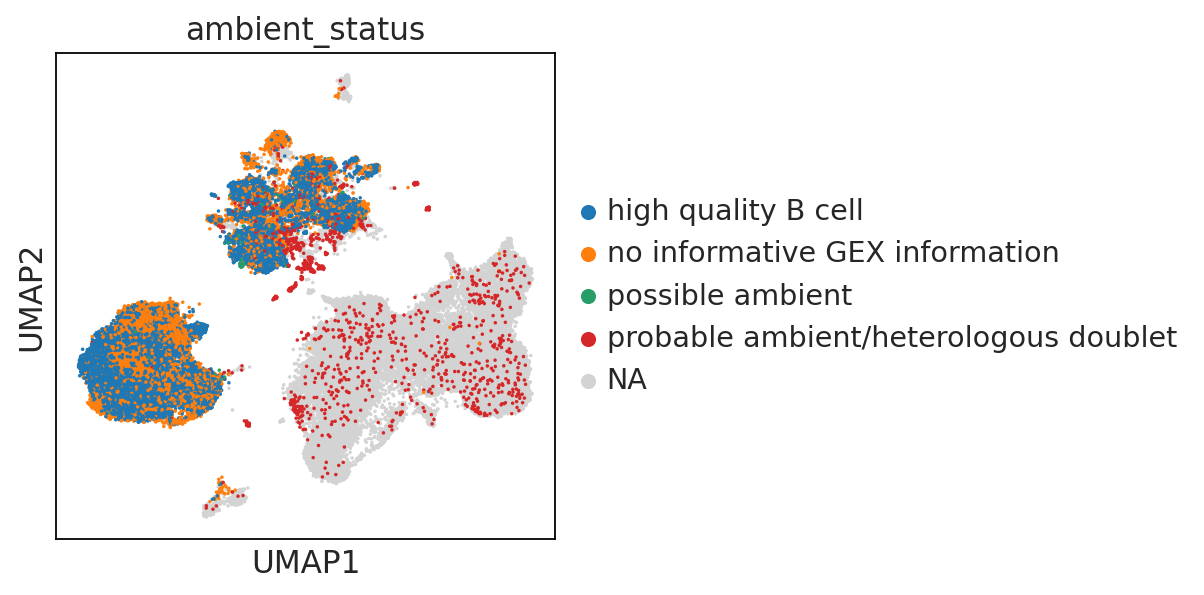

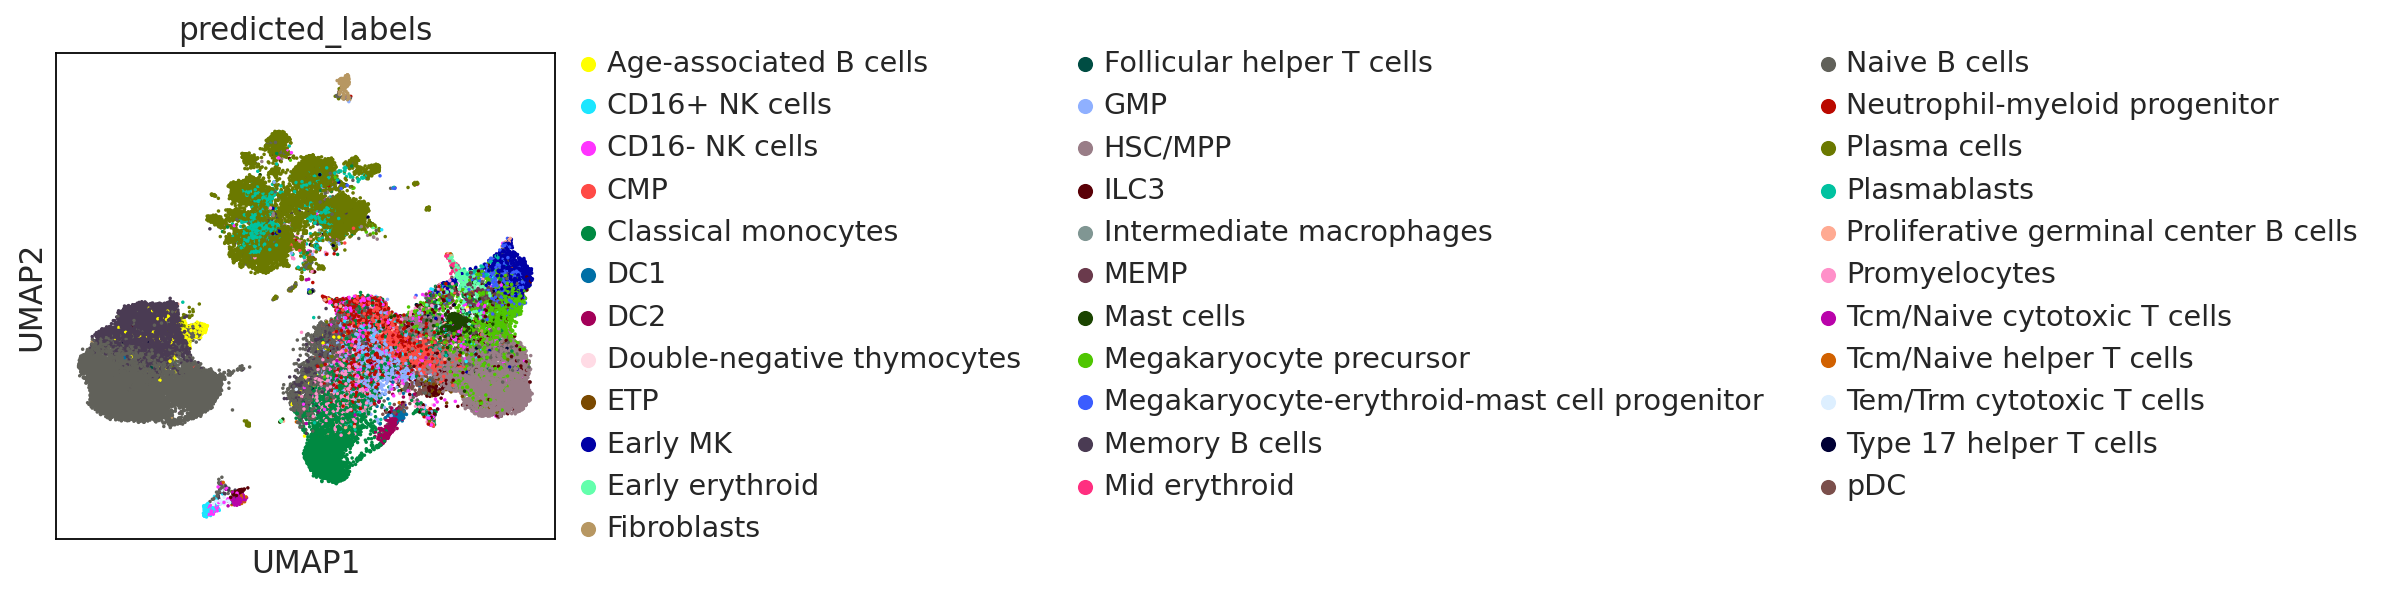

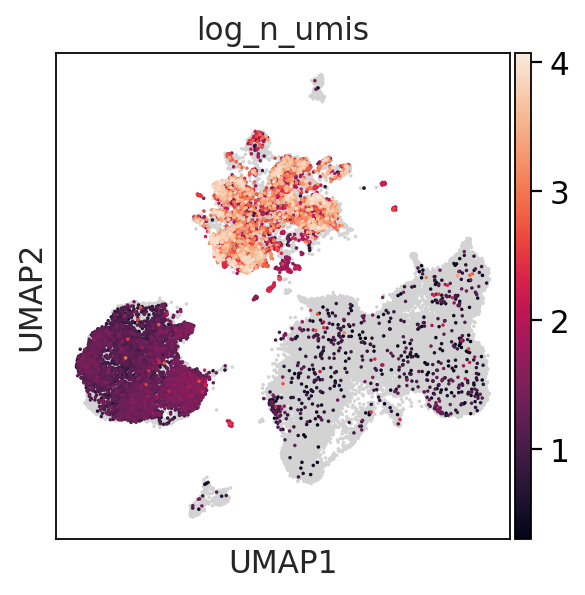

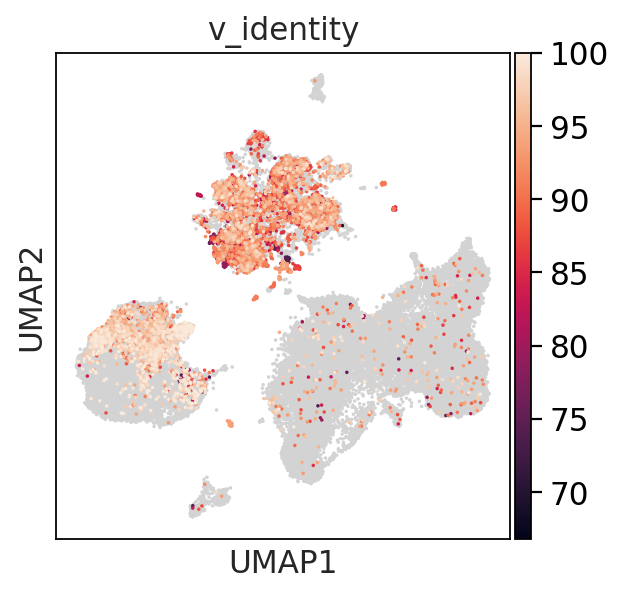

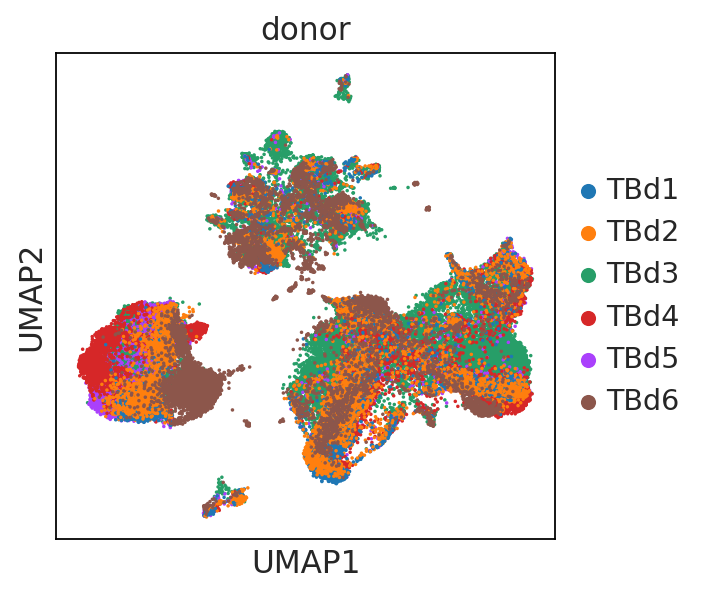

In [8]:
variables = ['ambient_status', 'predicted_labels', "log_n_umis", 'v_identity', 'donor']
for var in variables:
    sc.pl.umap(adata, color = var, size = 10, save = "{}_{}".format(var, tissue))

## umis by celltype

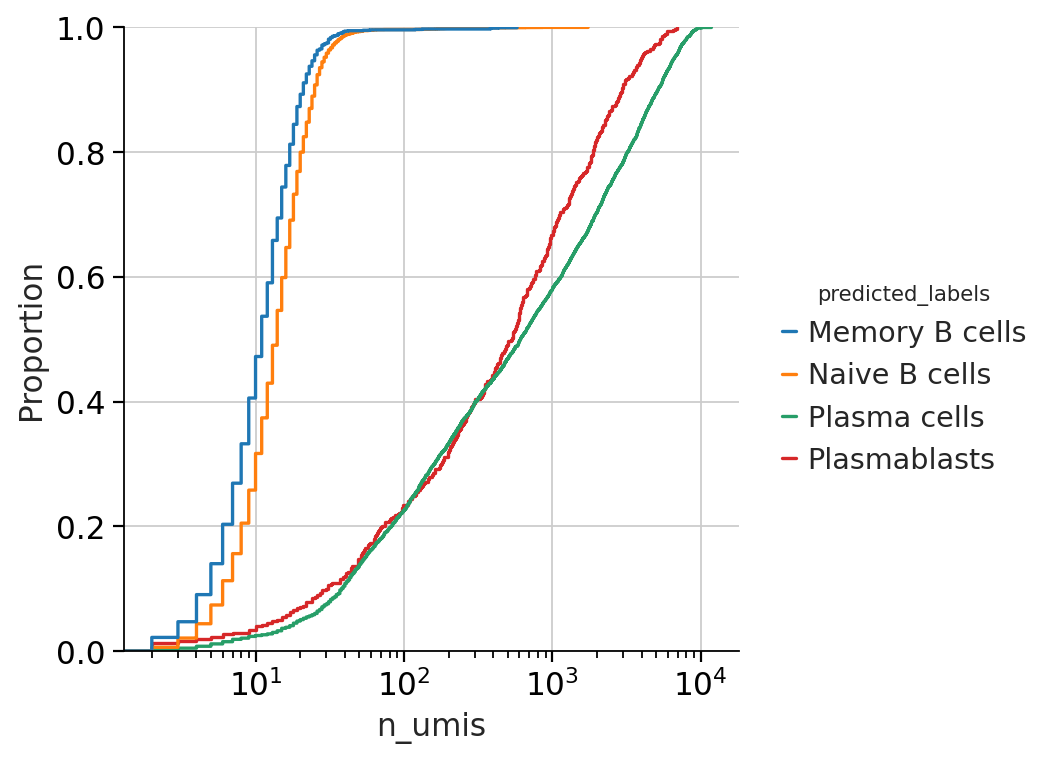

In [9]:
data = adata.obs[adata.obs.predicted_labels.str.contains("Naive B|Memory|Plasma")]
data.predicted_labels.cat.remove_unused_categories(inplace = True)
hue = 'predicted_labels'
kind = 'ecdf'
x = "n_umis"
g = sns.displot(data = data, x = x, kind = kind, log_scale=True, hue = hue)
save_figure(g.fig, "{}_n_umis_{}".format(x,kind,hue))

In [10]:
# Is the total counts coming from IgH locus related to detection in the amplicon sequencing
umis = adata.to_df(layer = 'umi_counts')

In [11]:
adata.obs['gex_igh_umis'] = umis[igh_genes].sum(axis = 1)

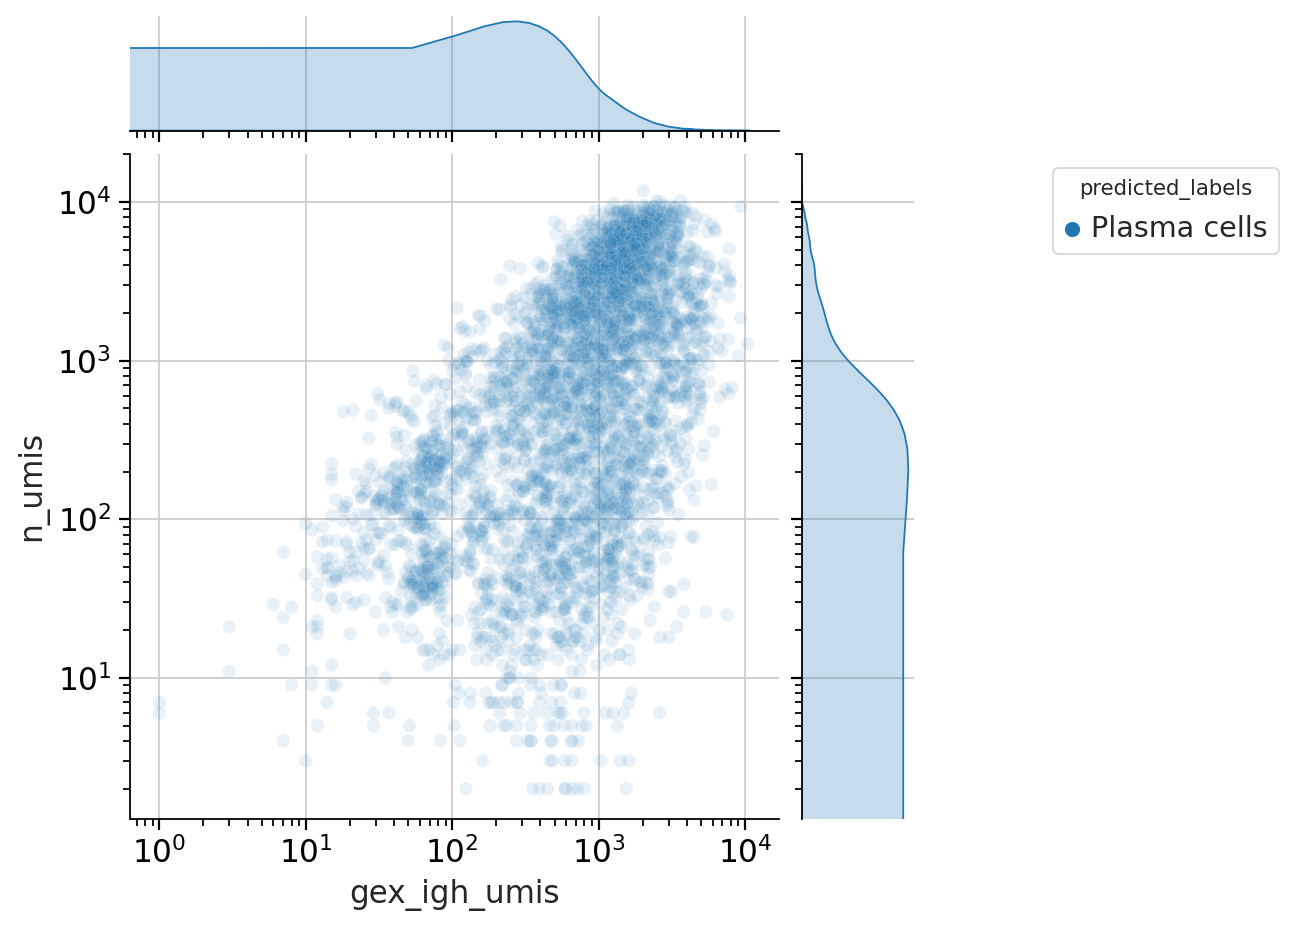

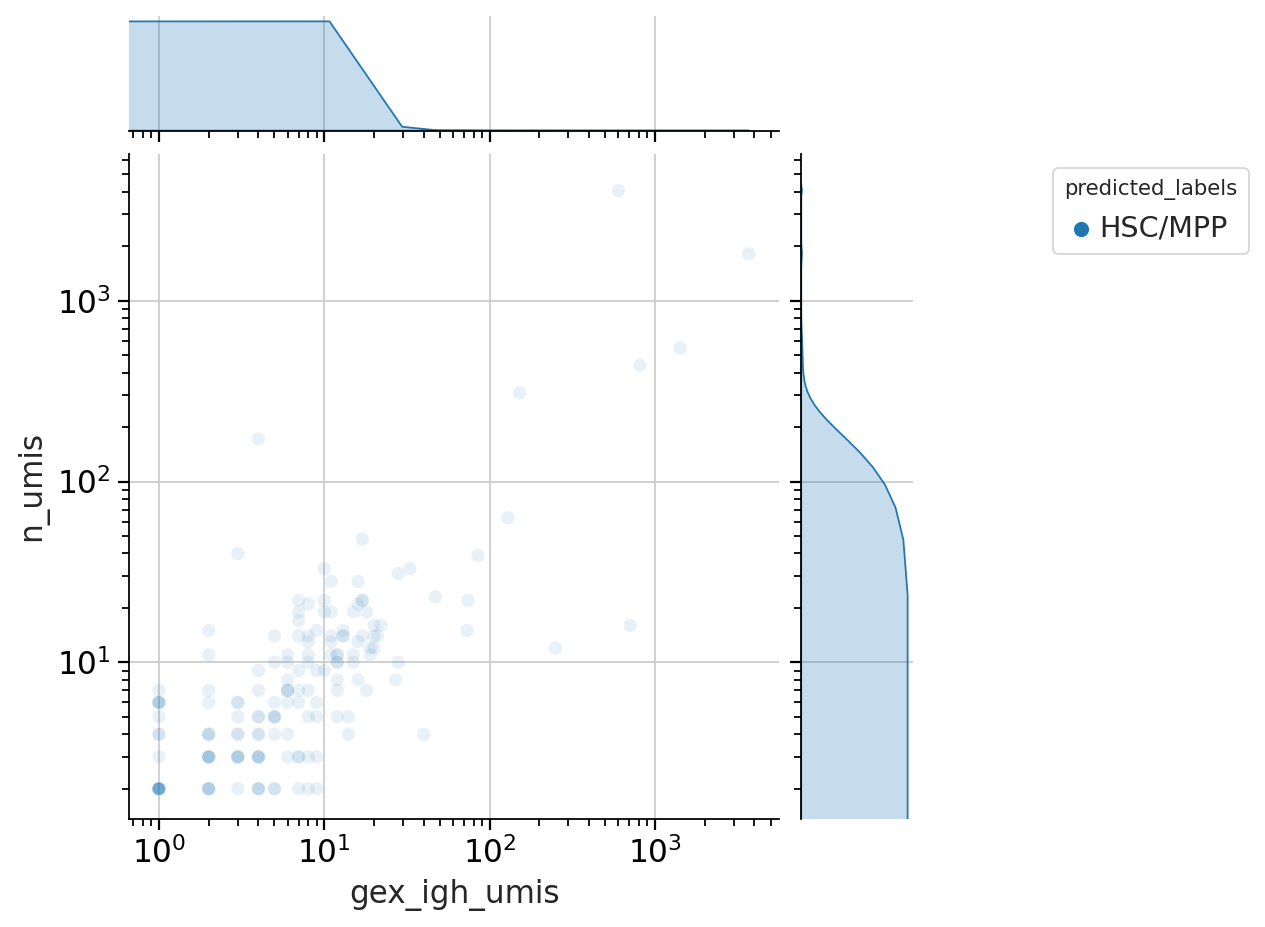

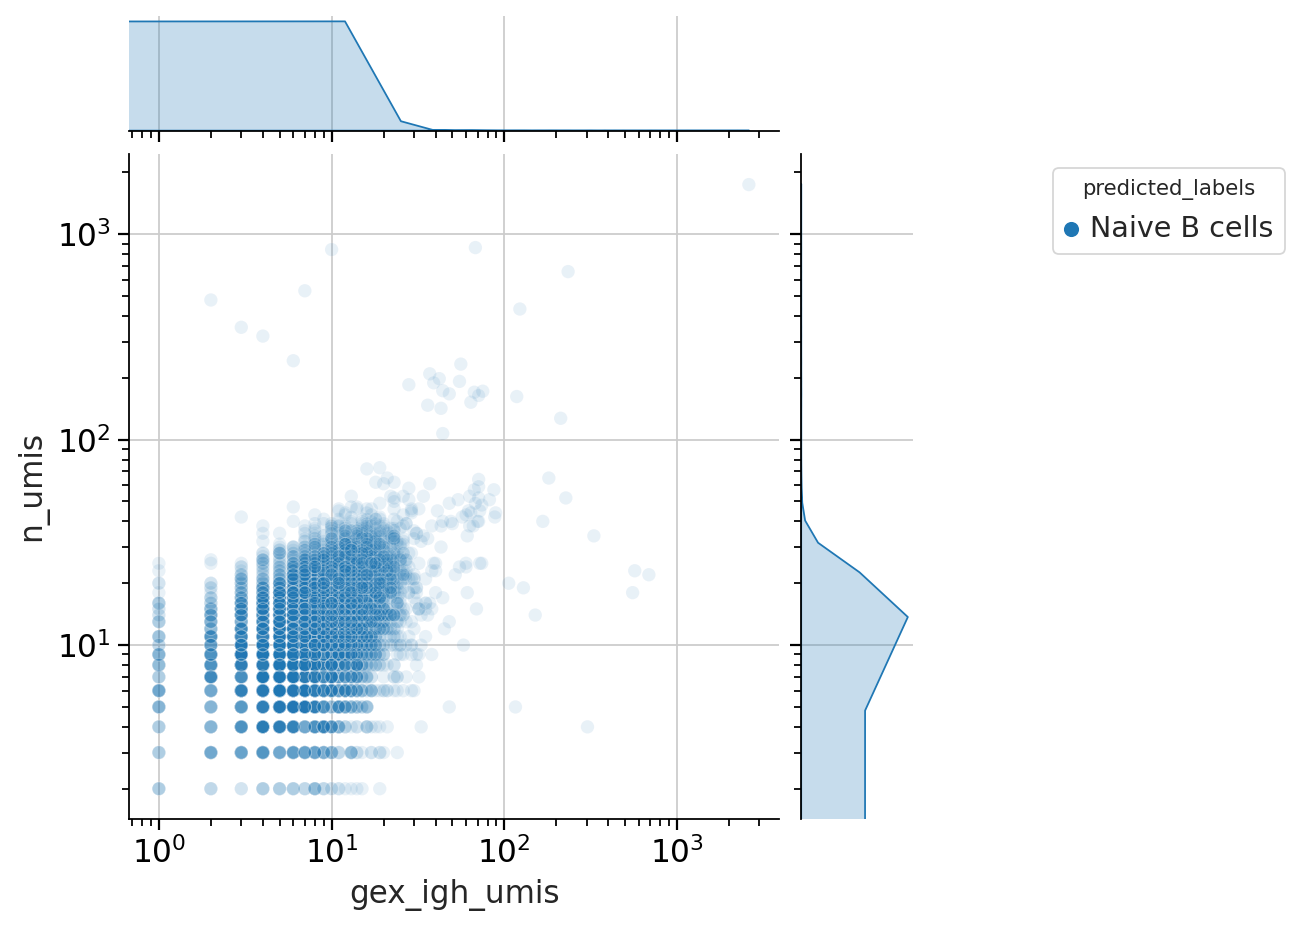

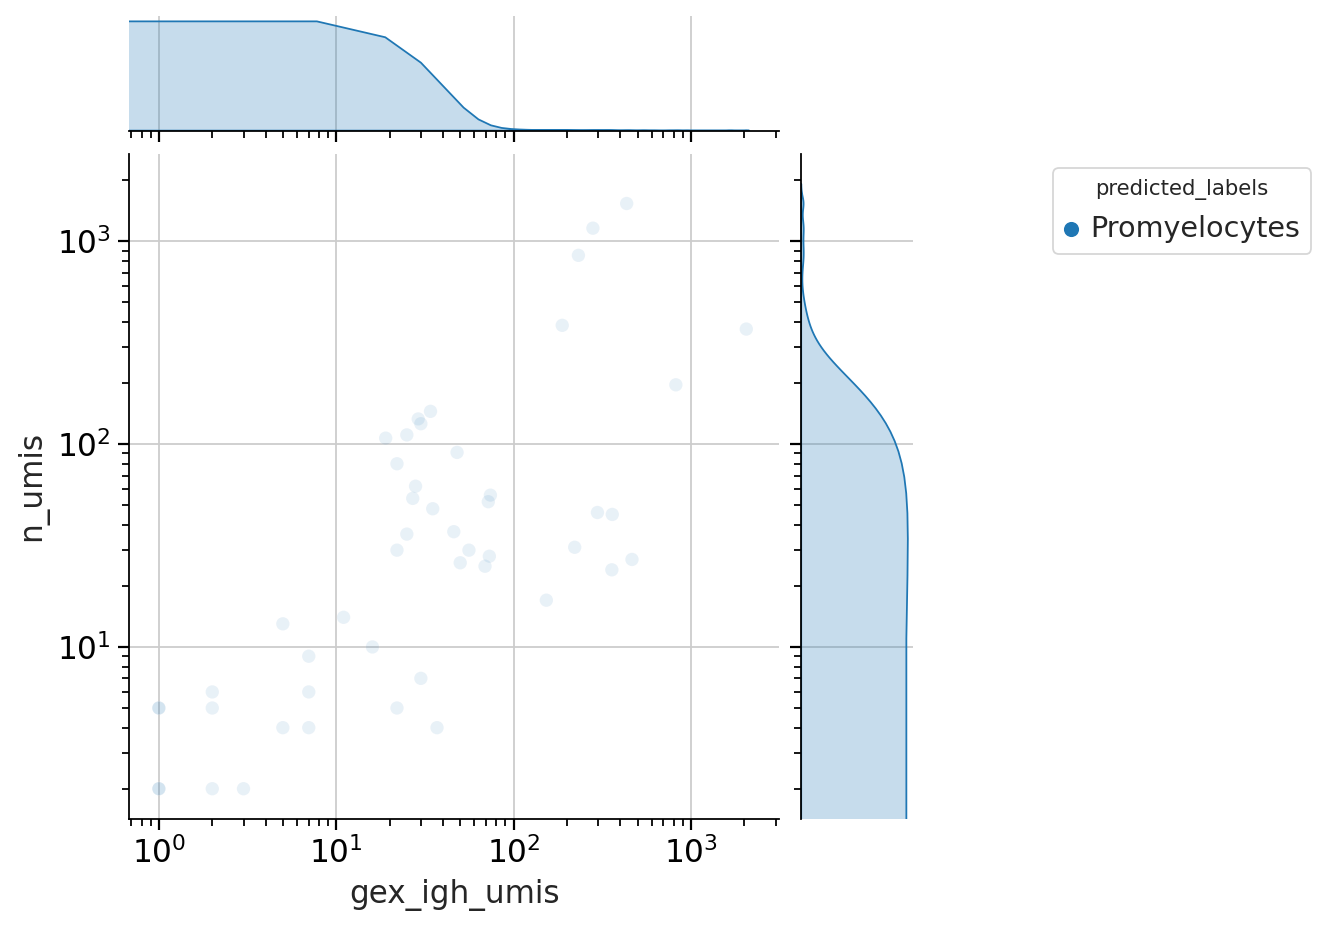

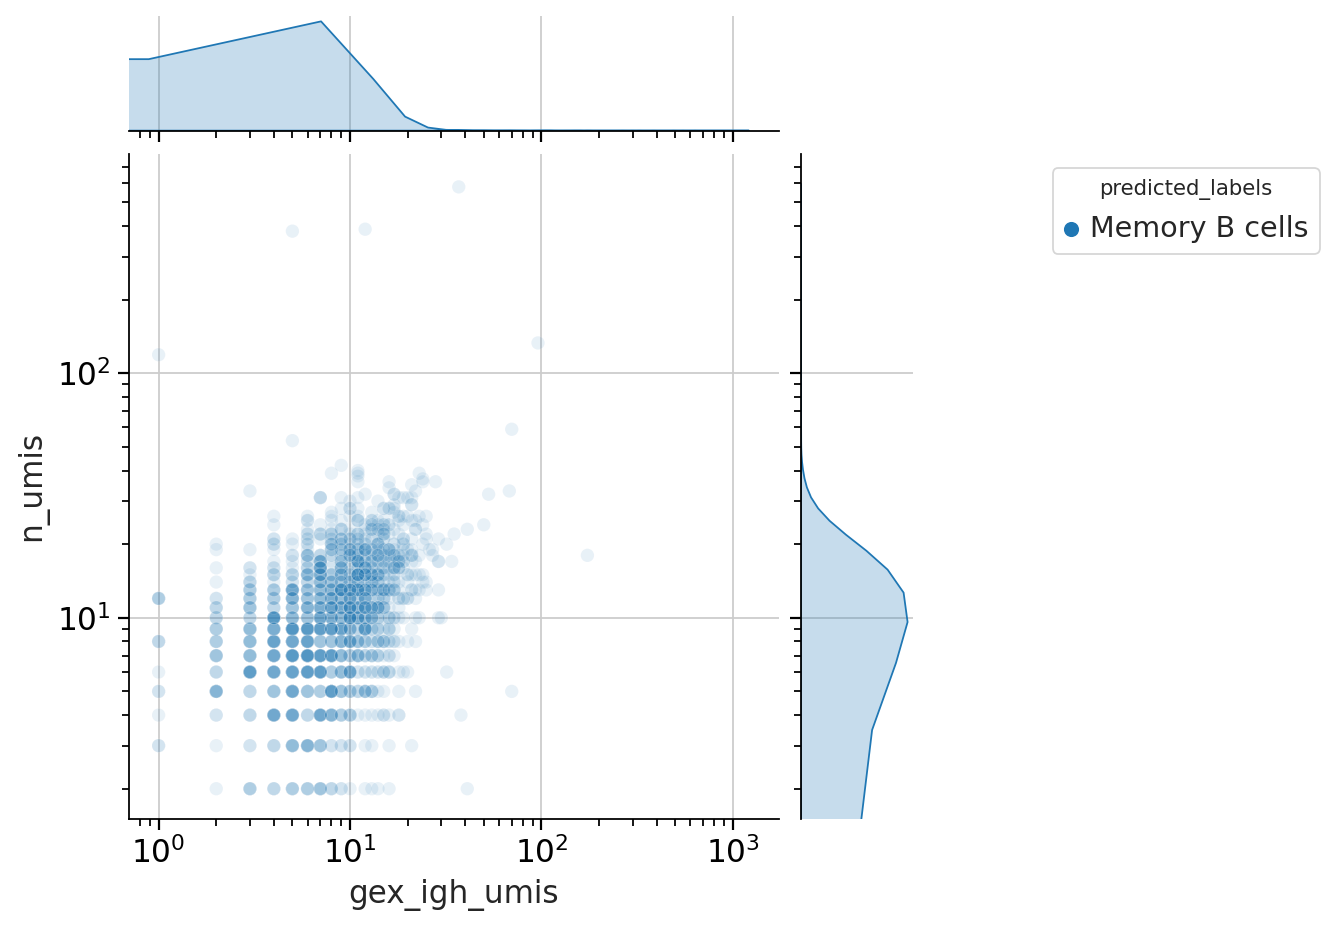

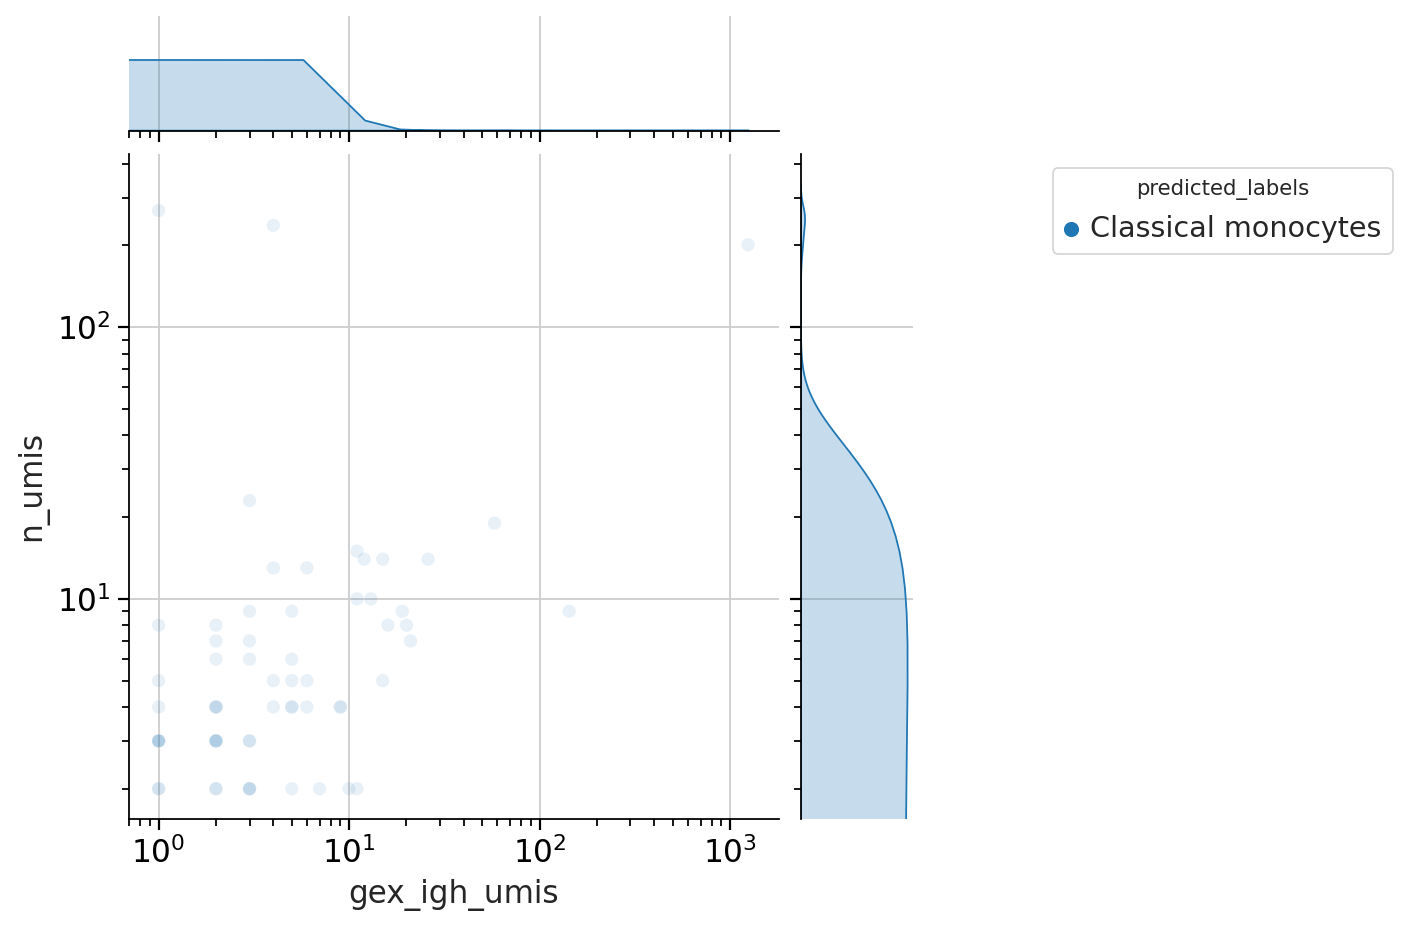

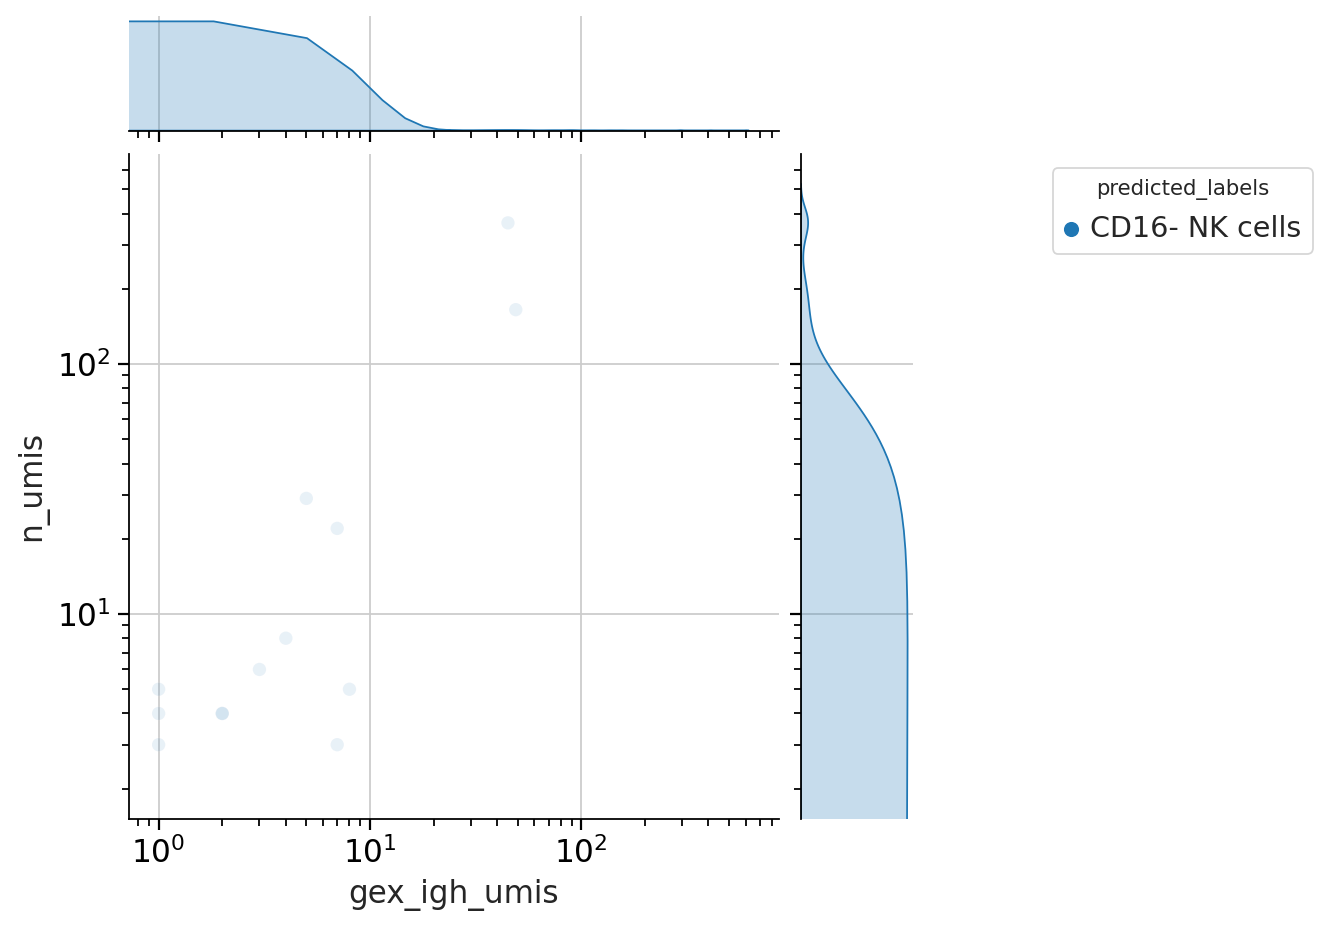

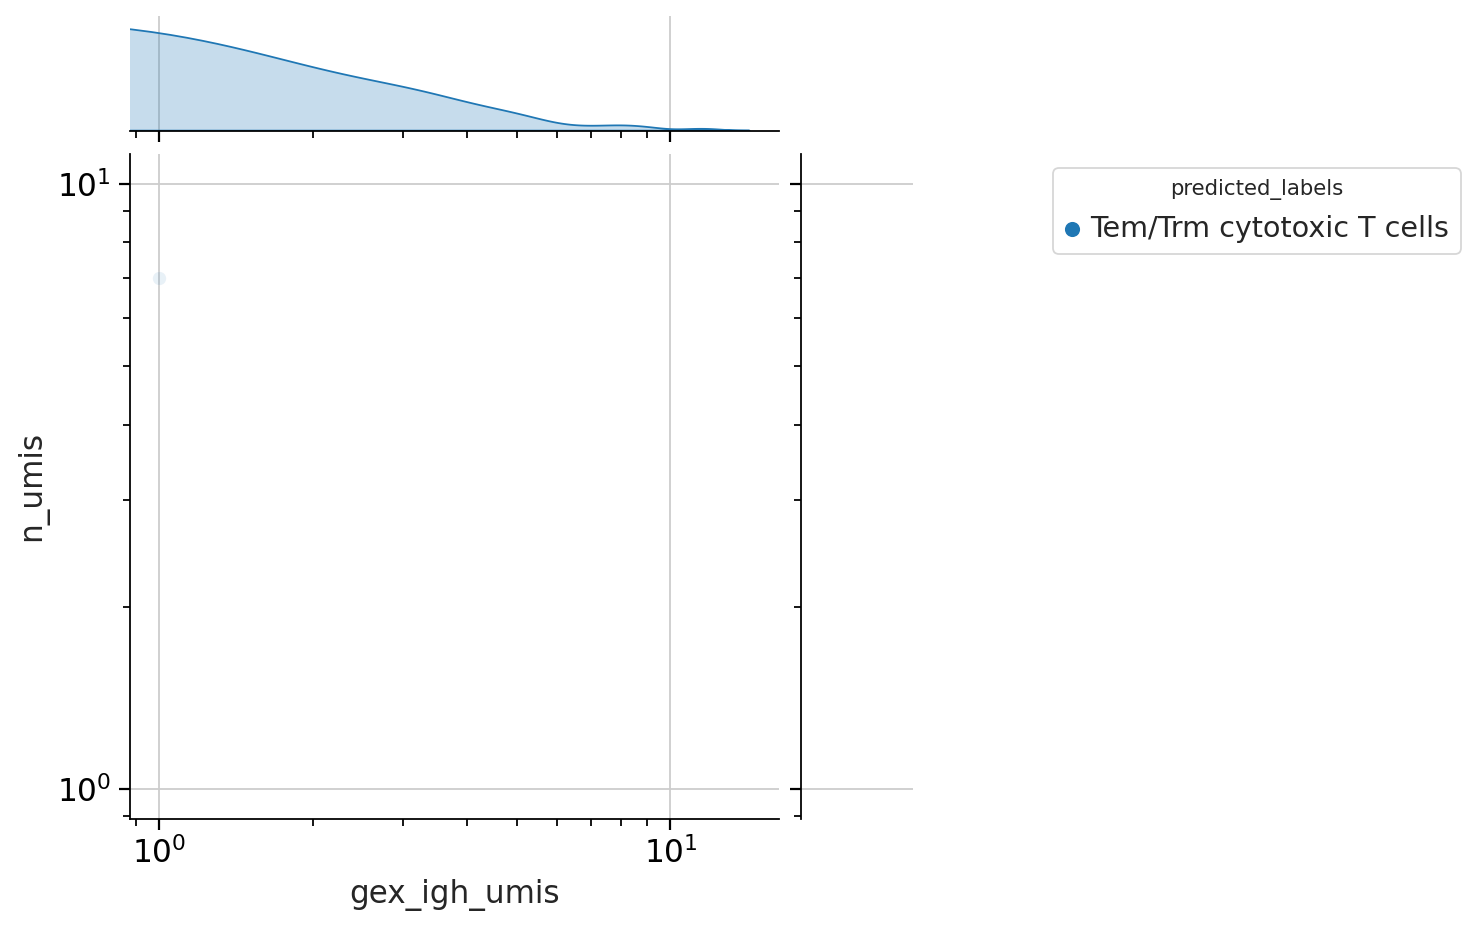

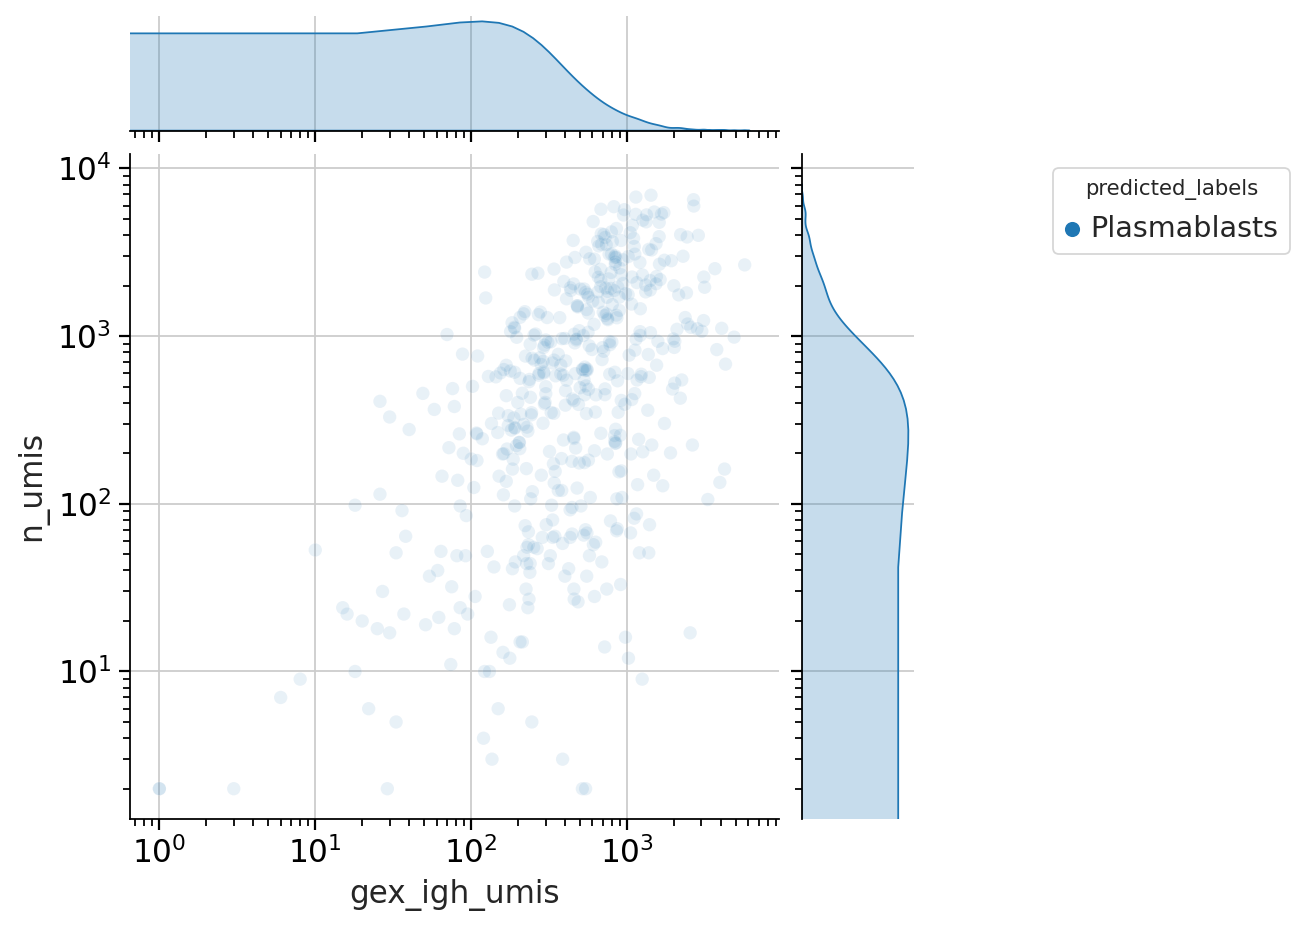

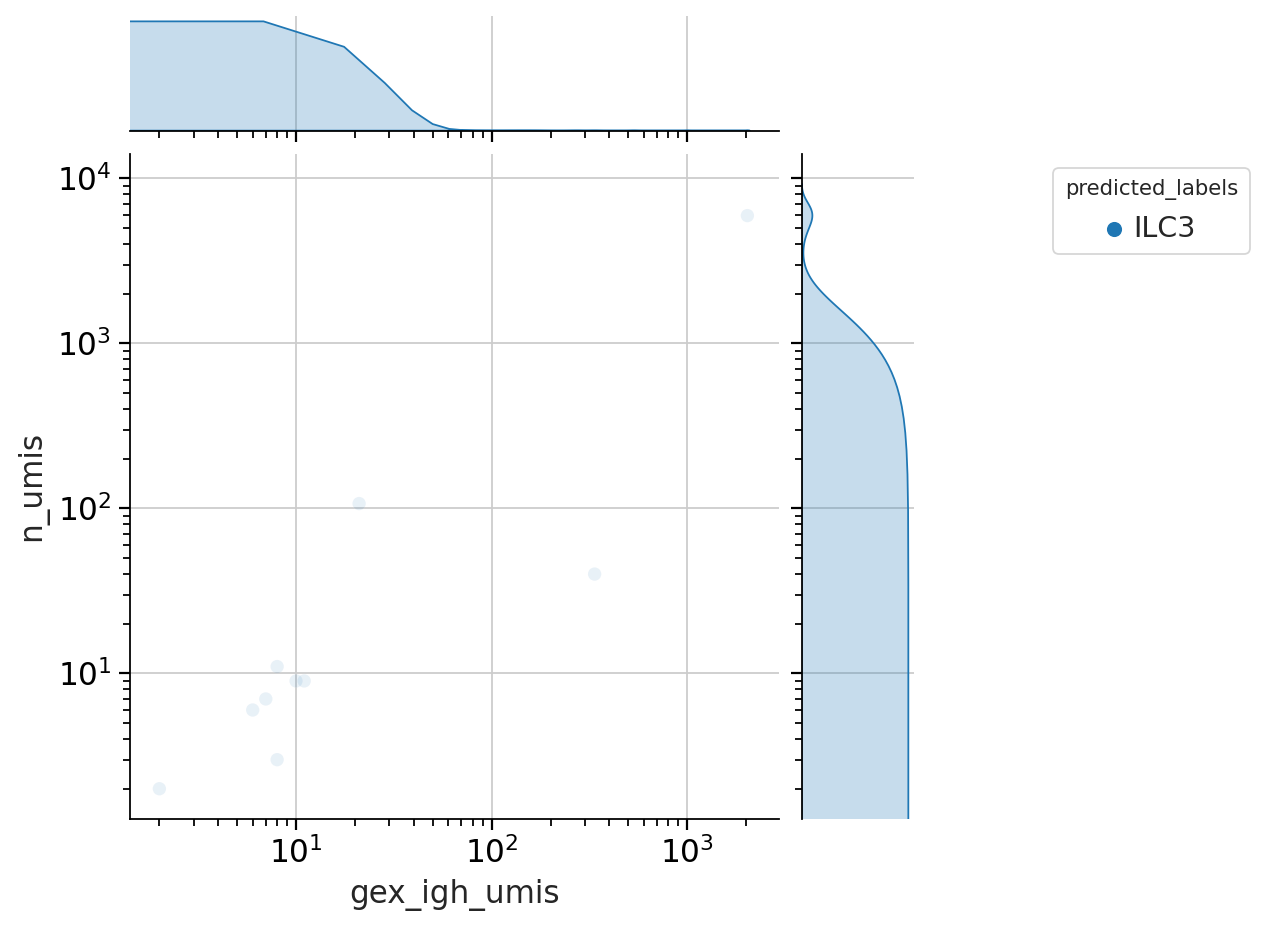

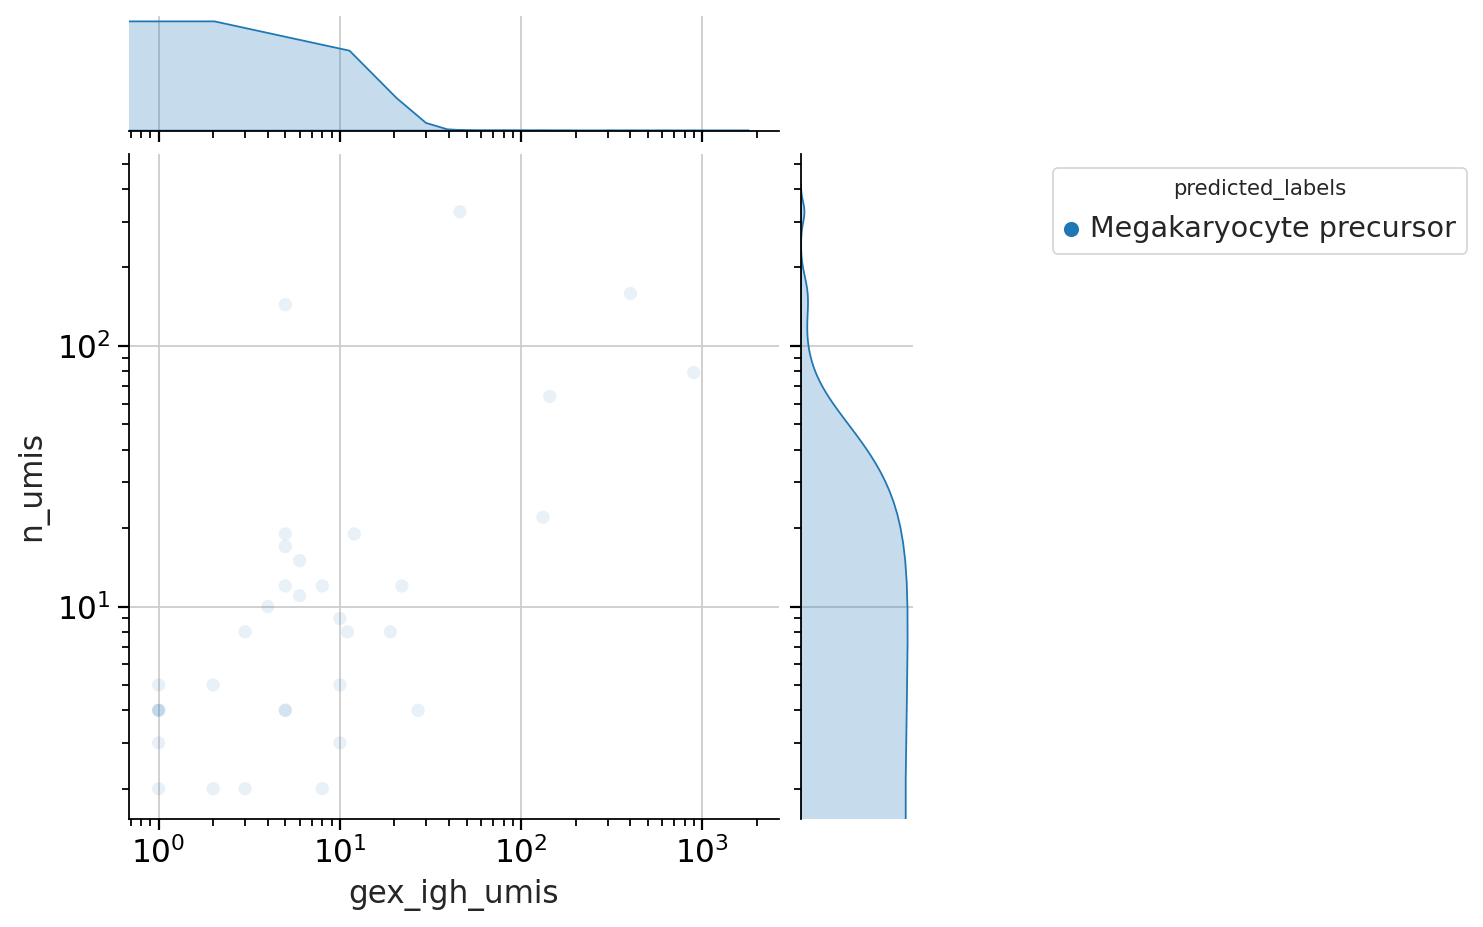

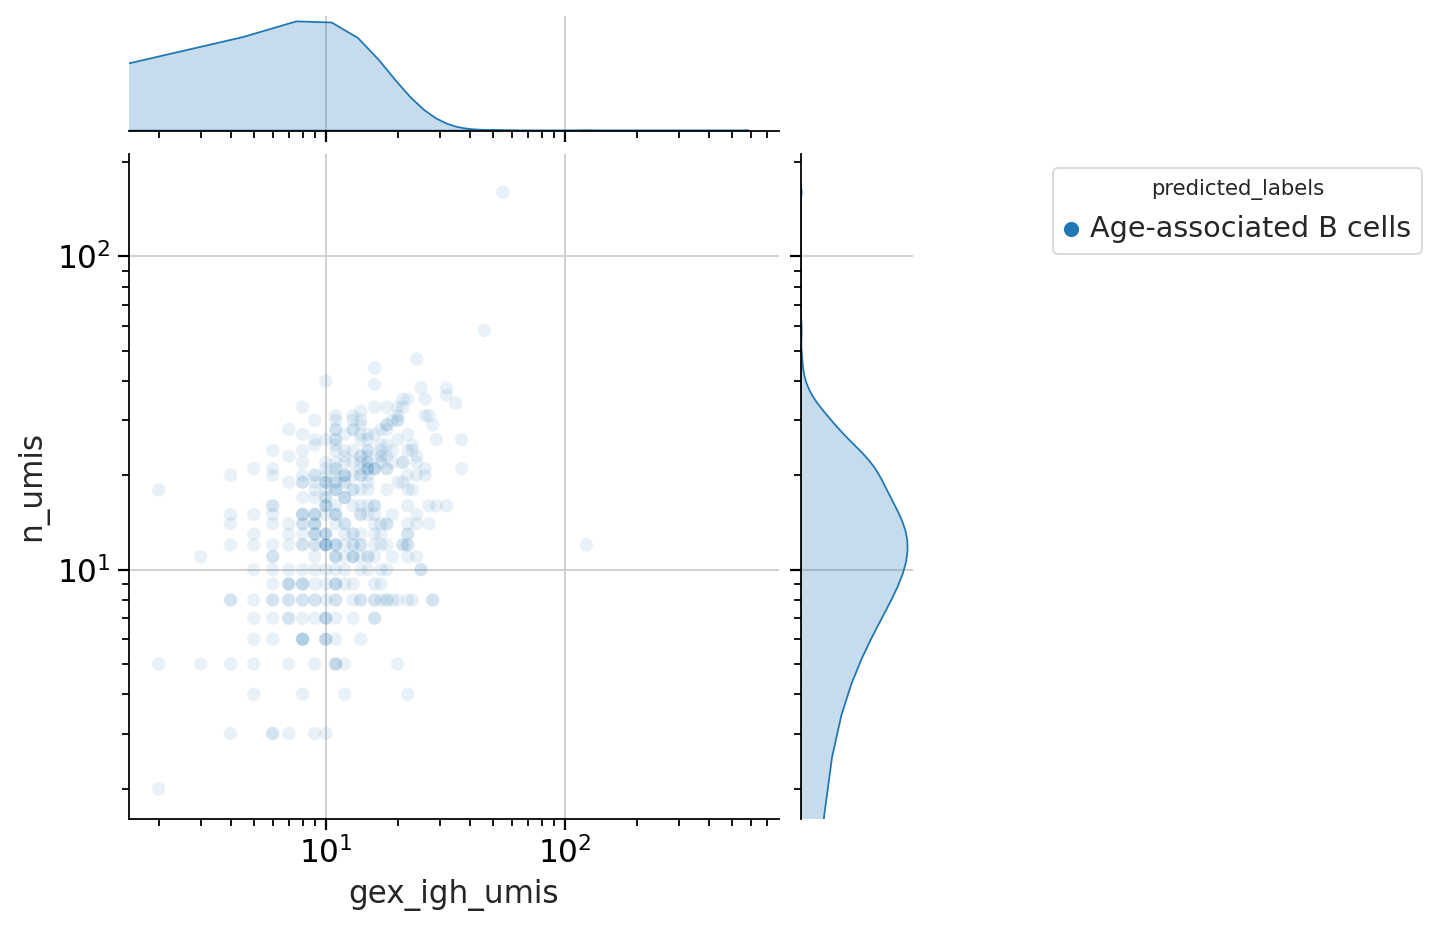

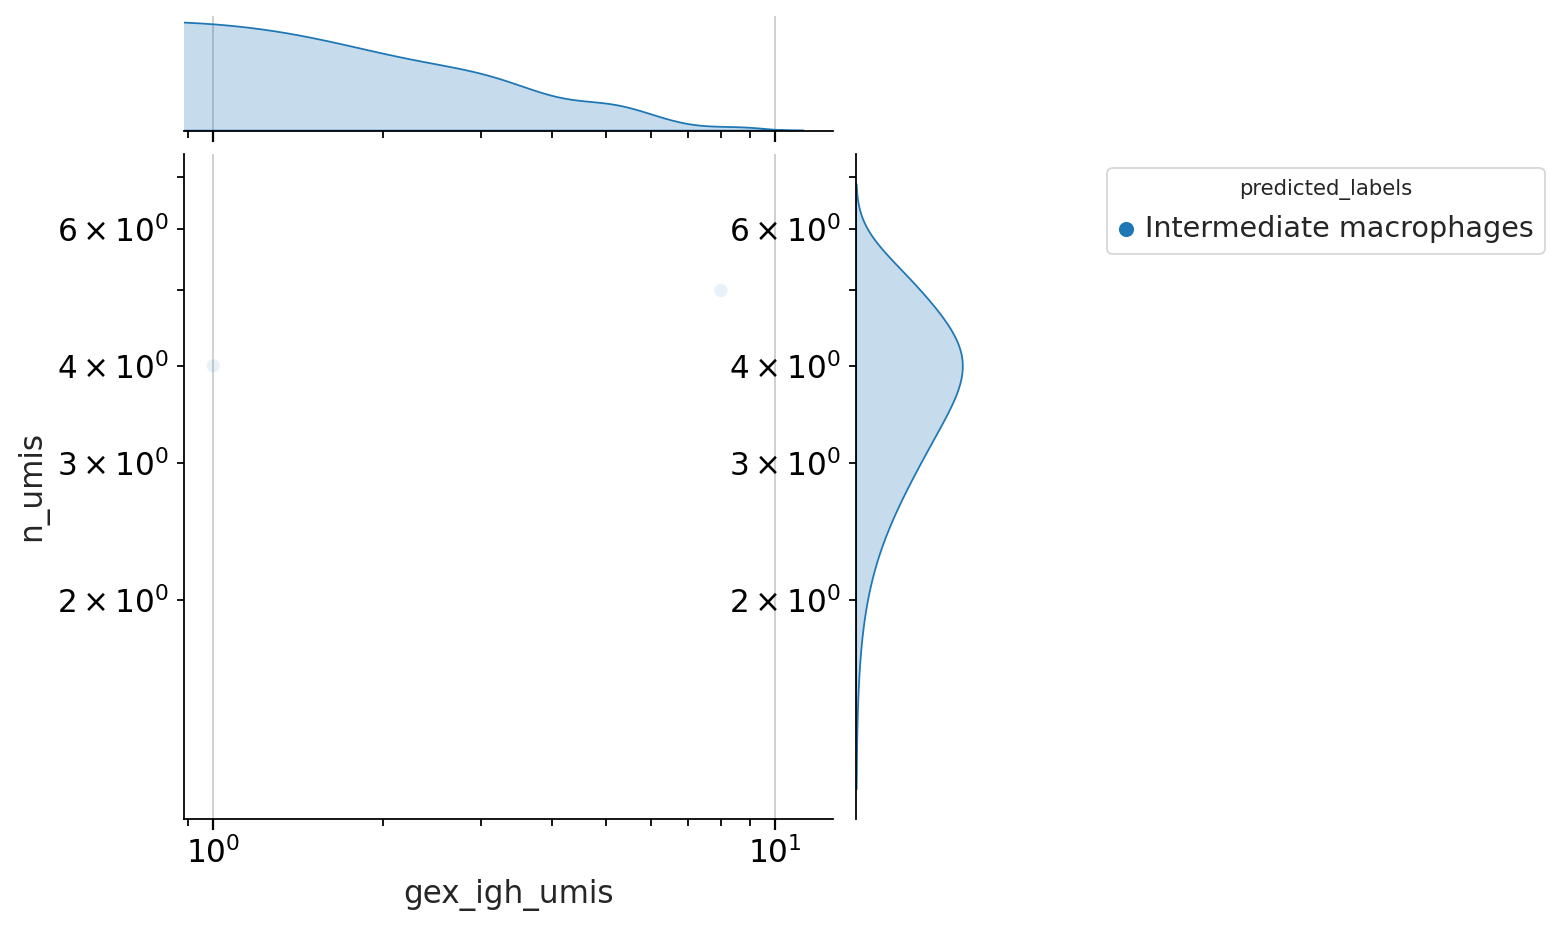

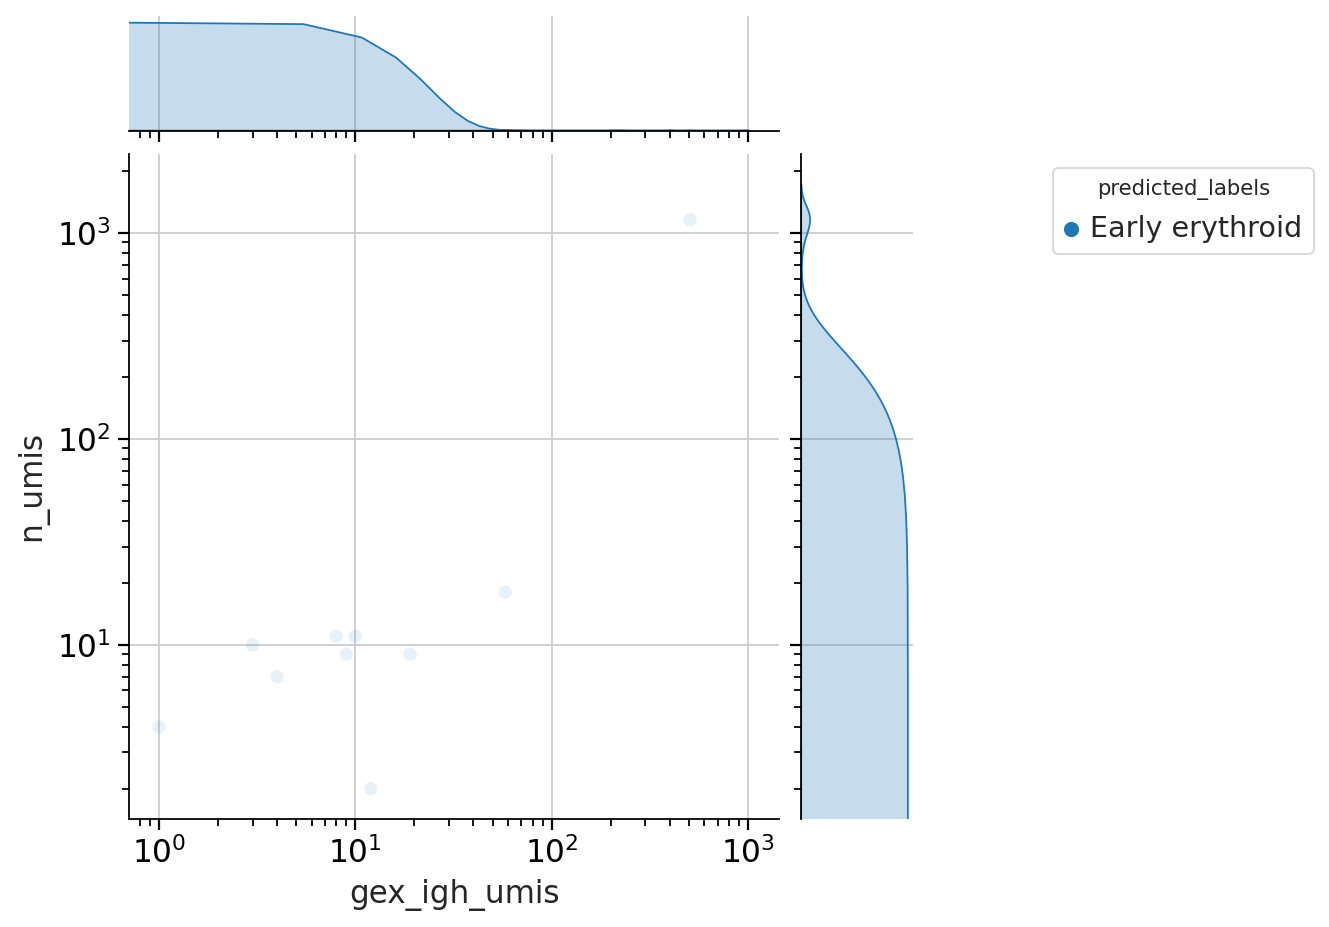

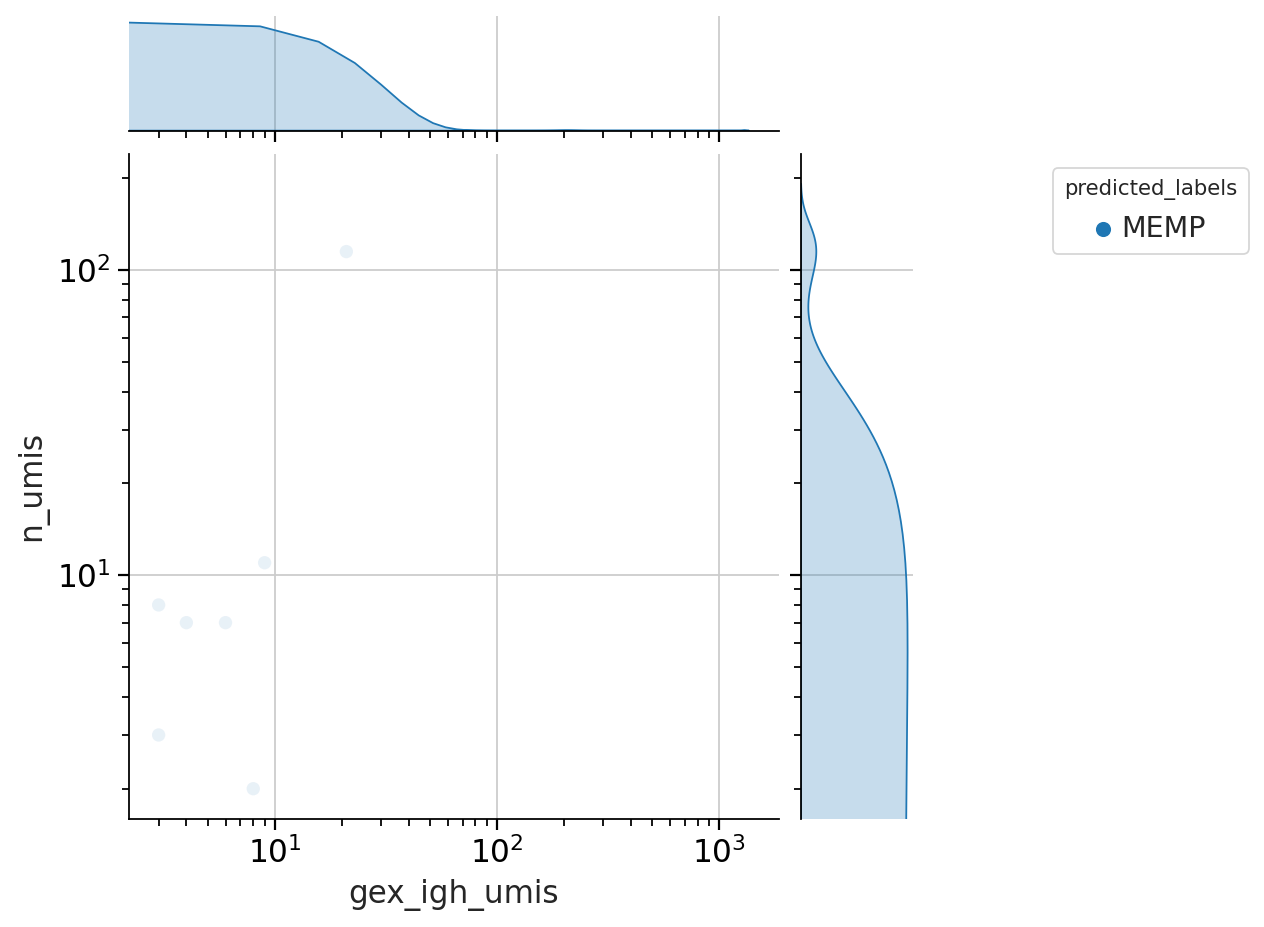

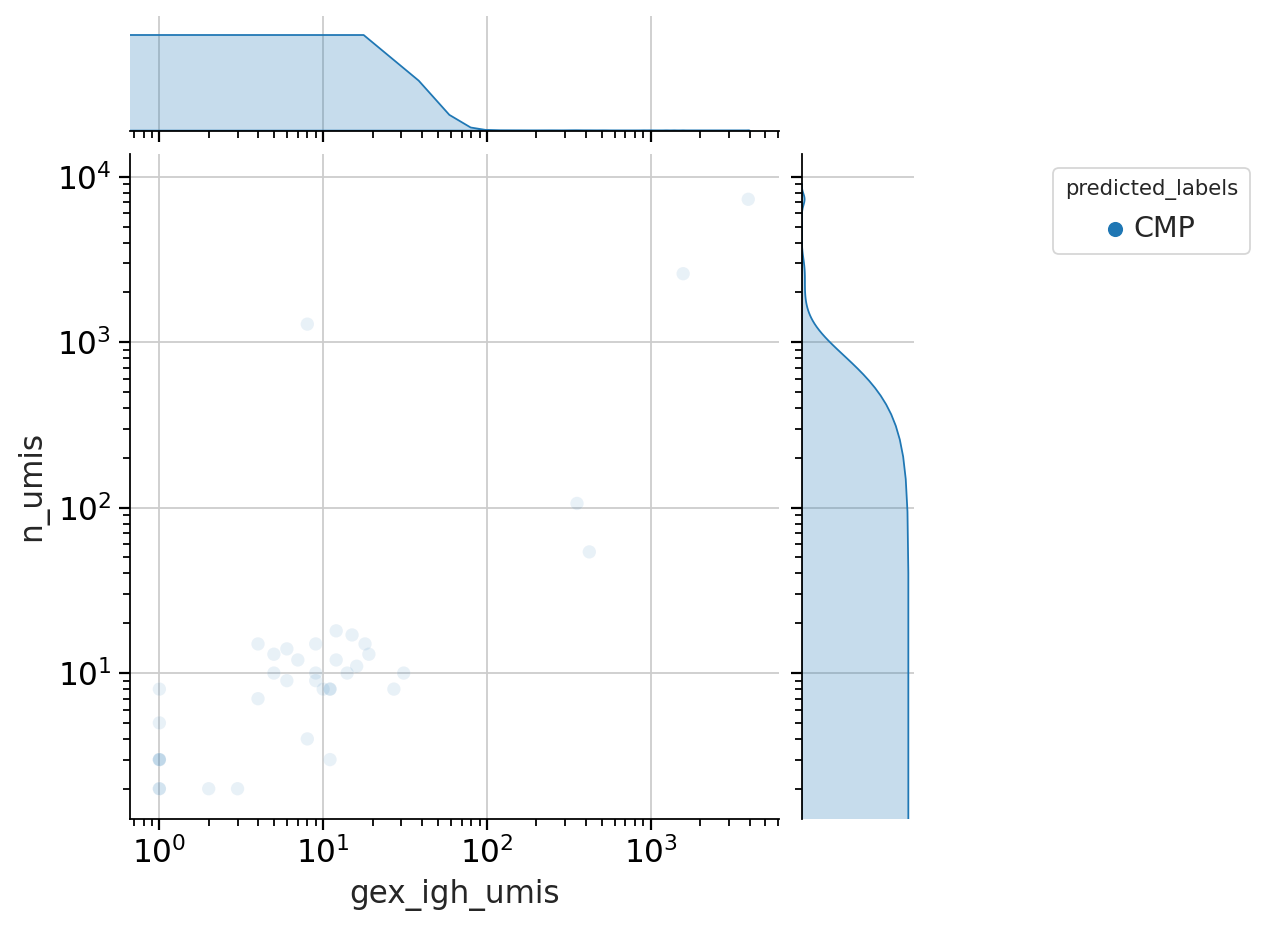

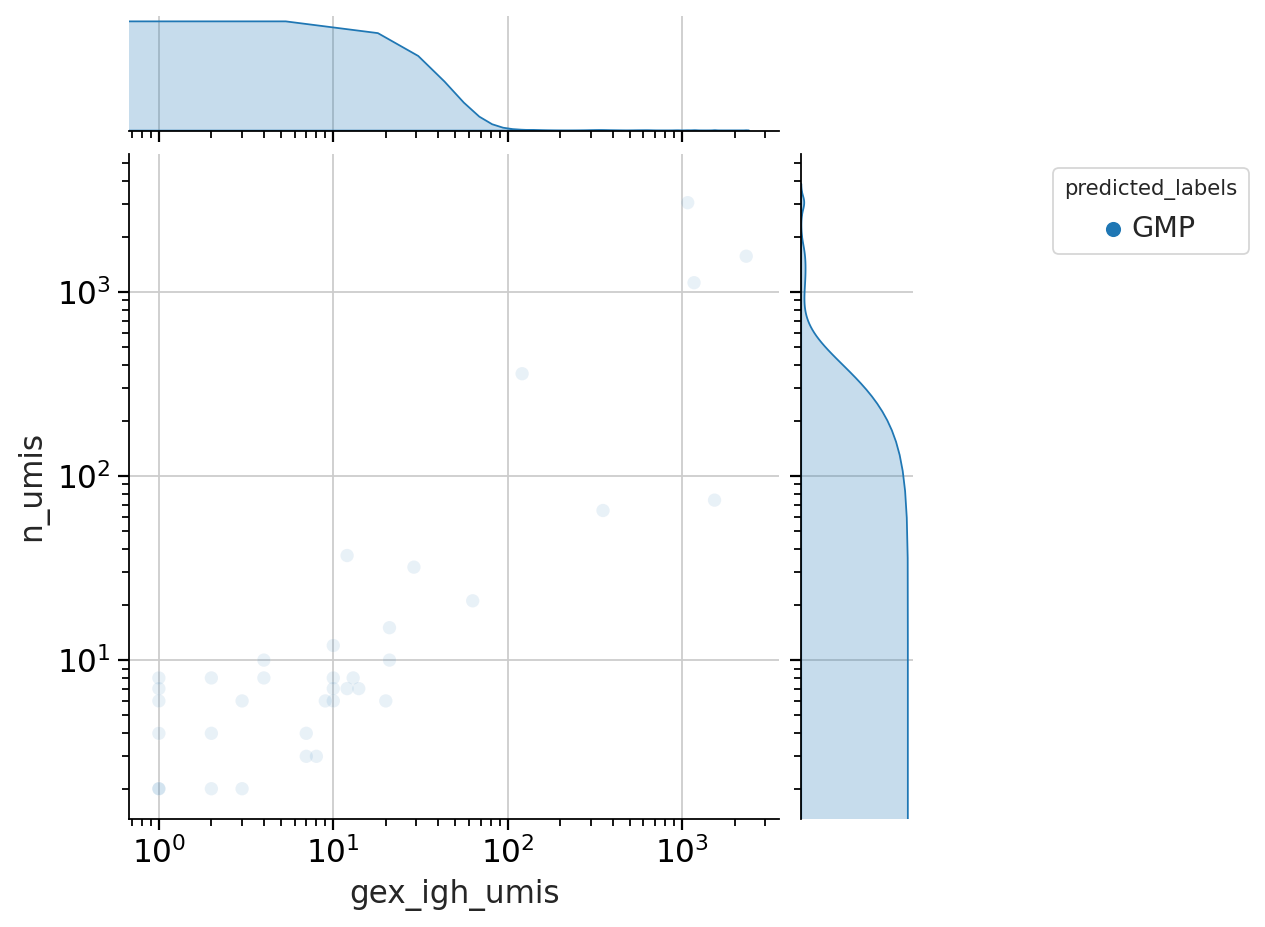

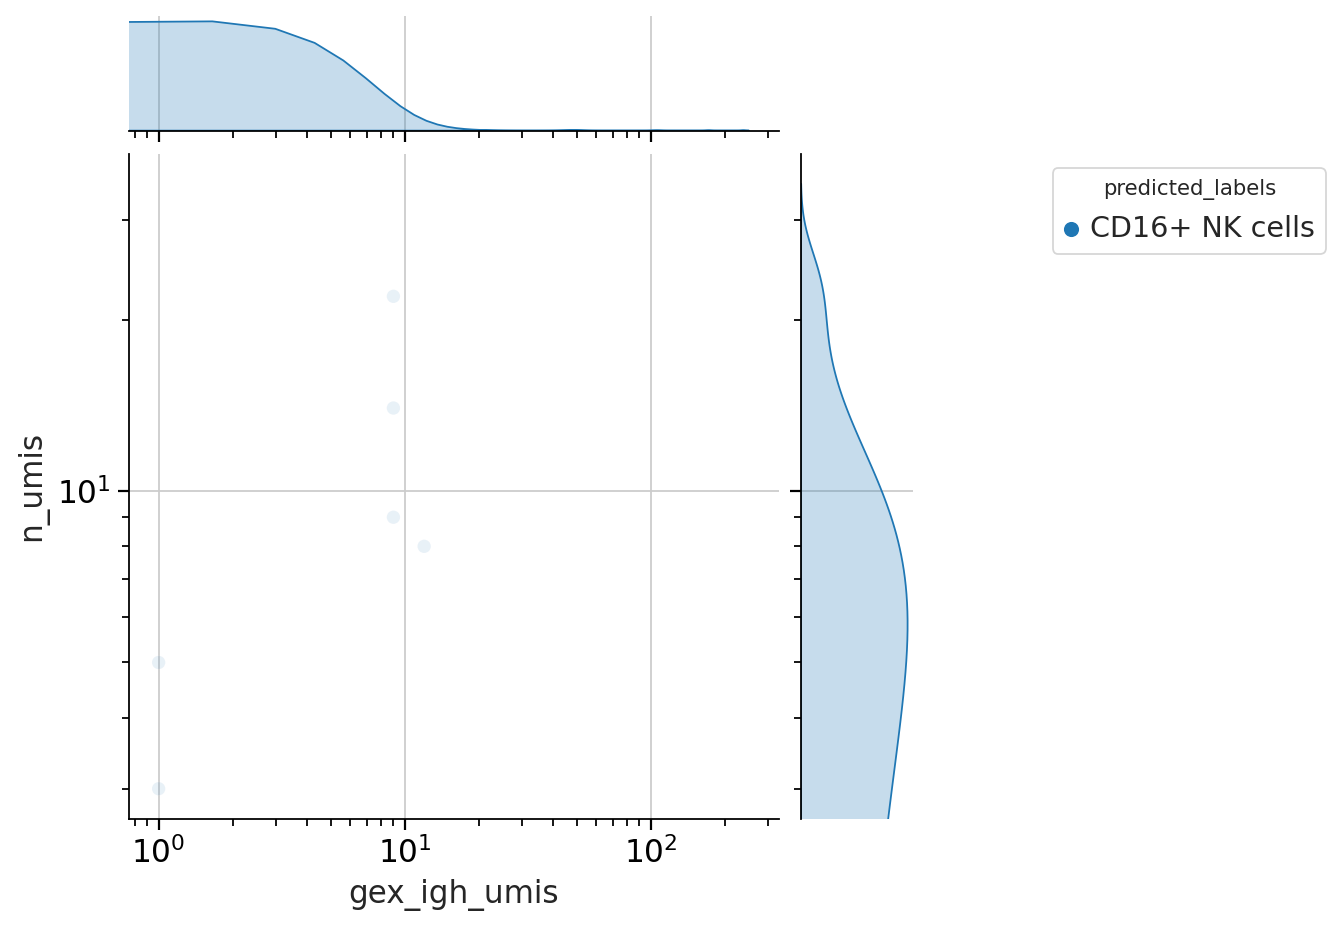

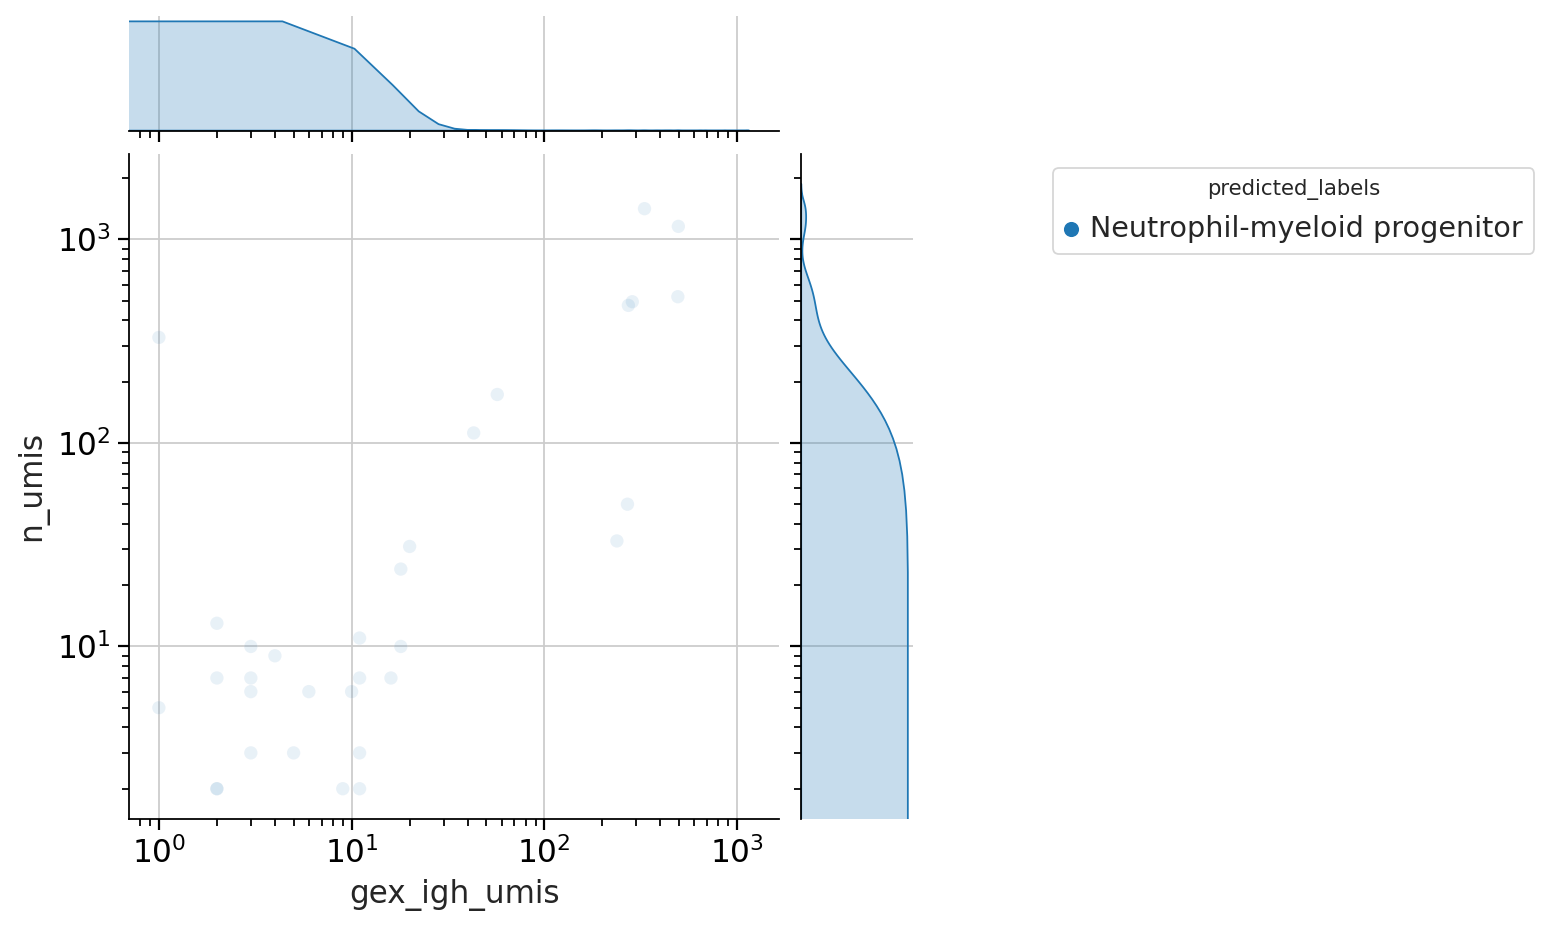

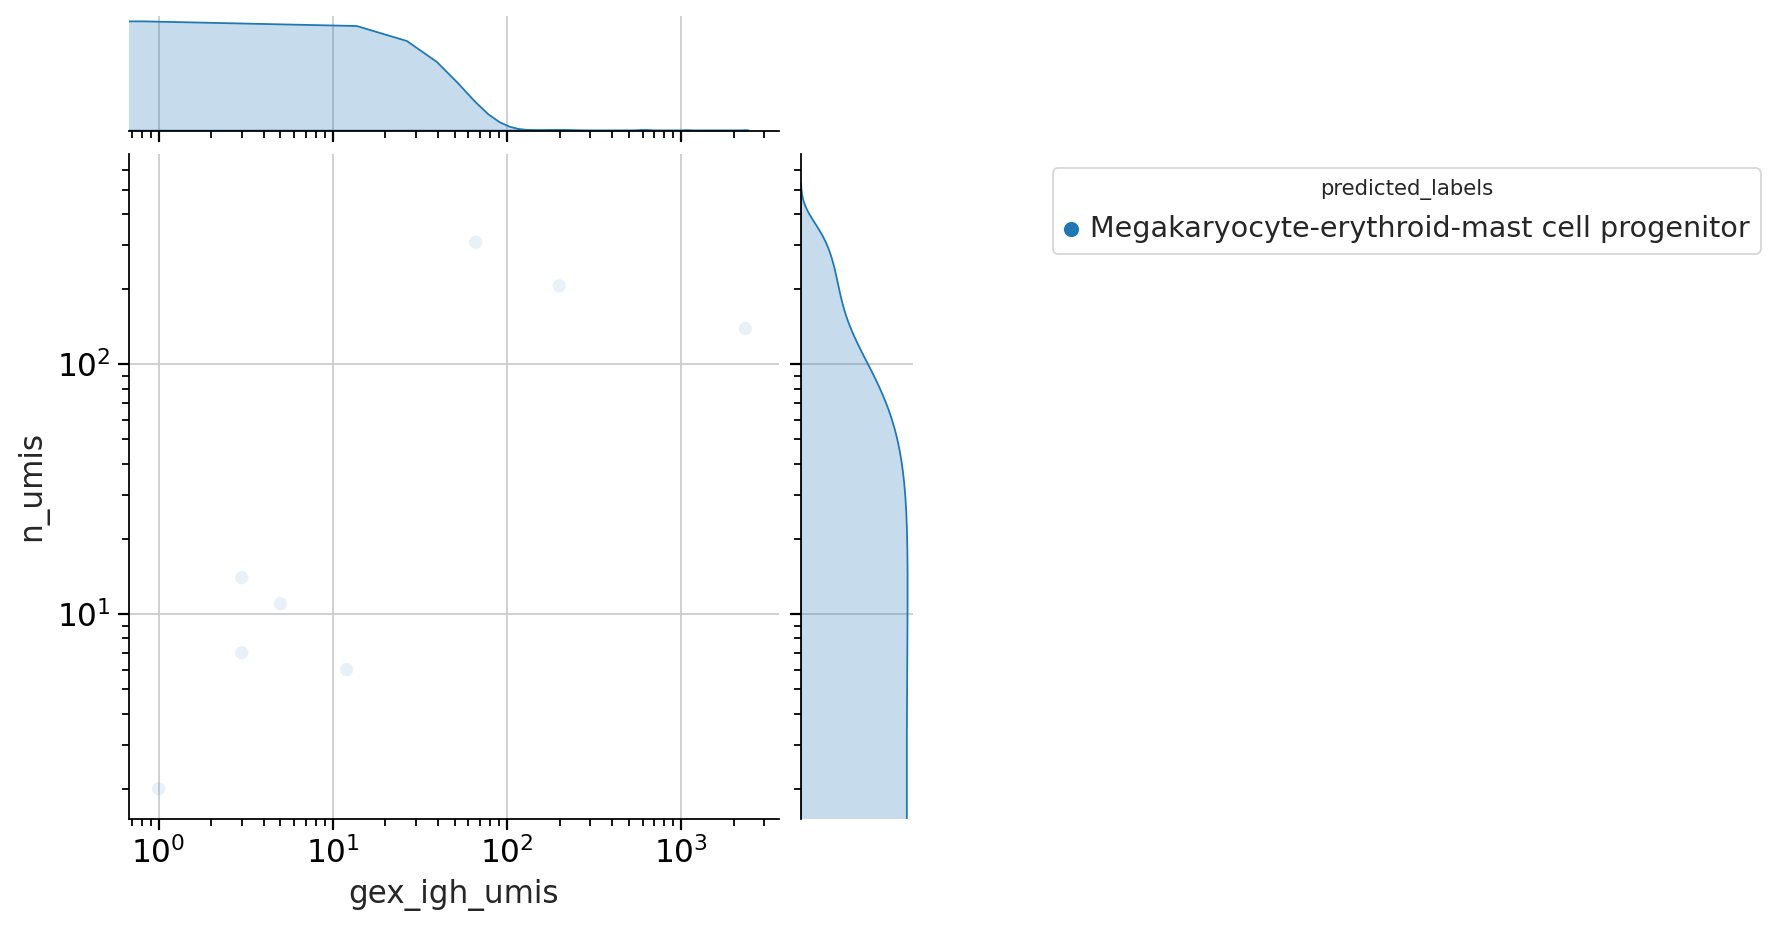

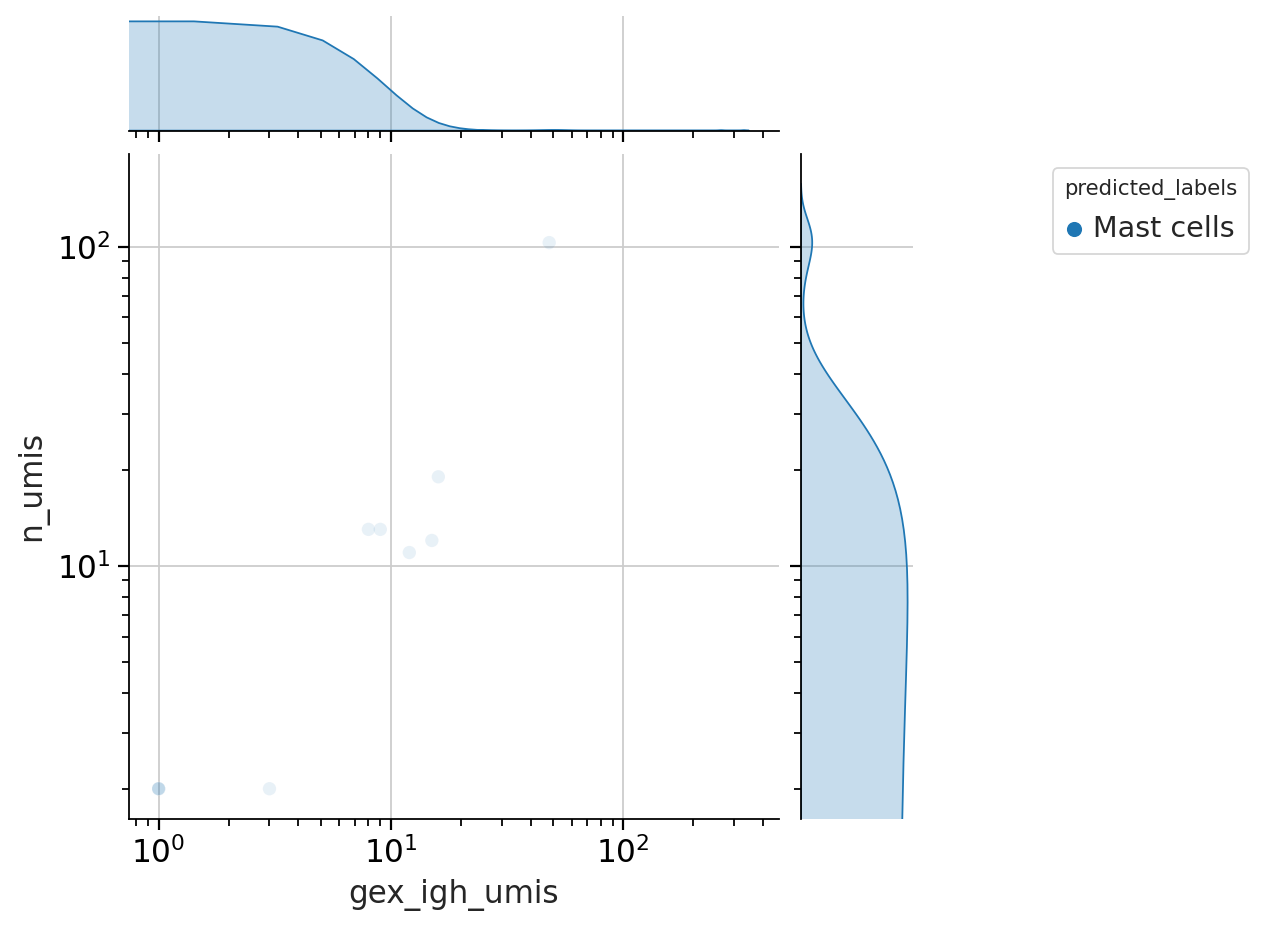

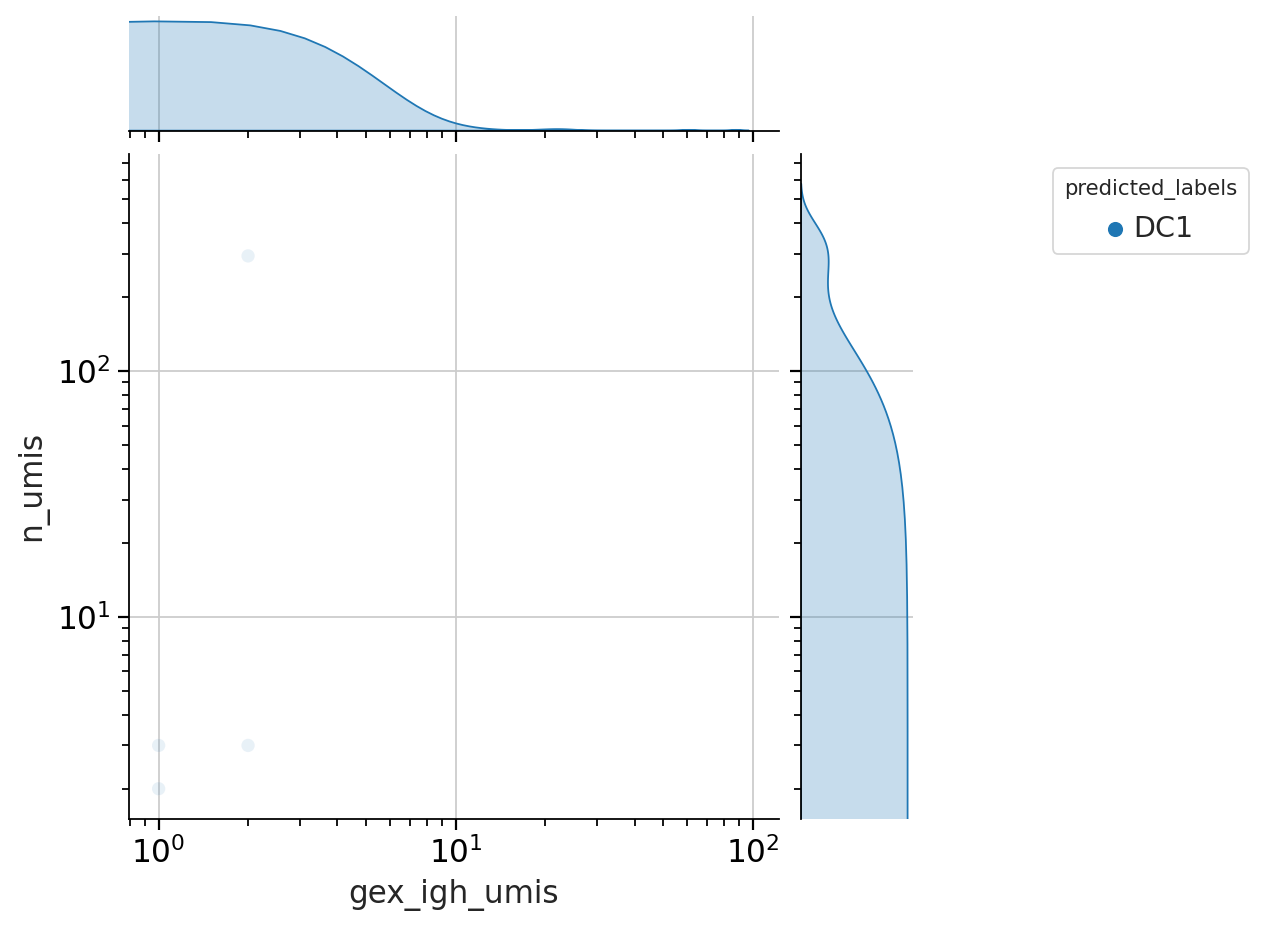

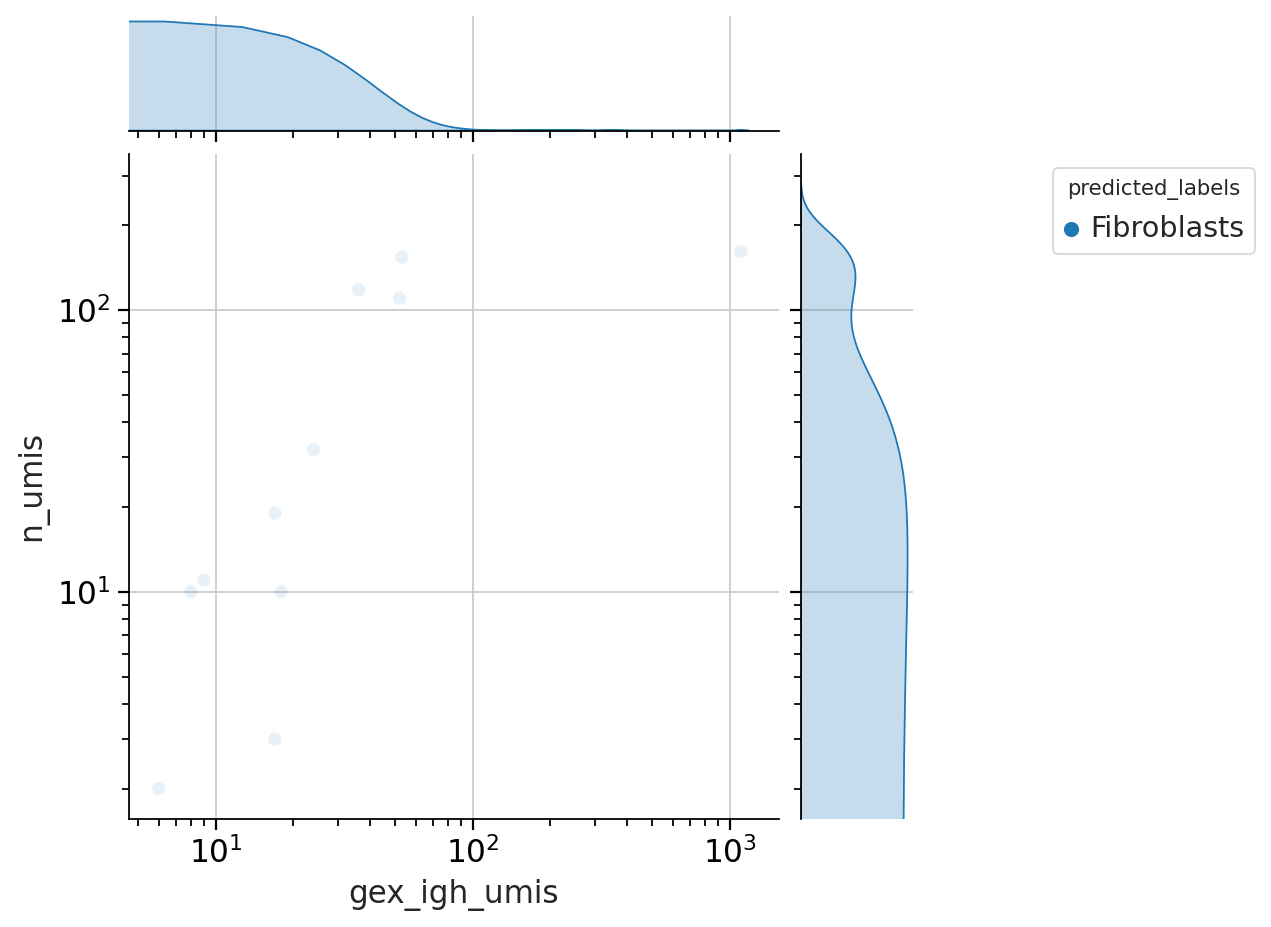

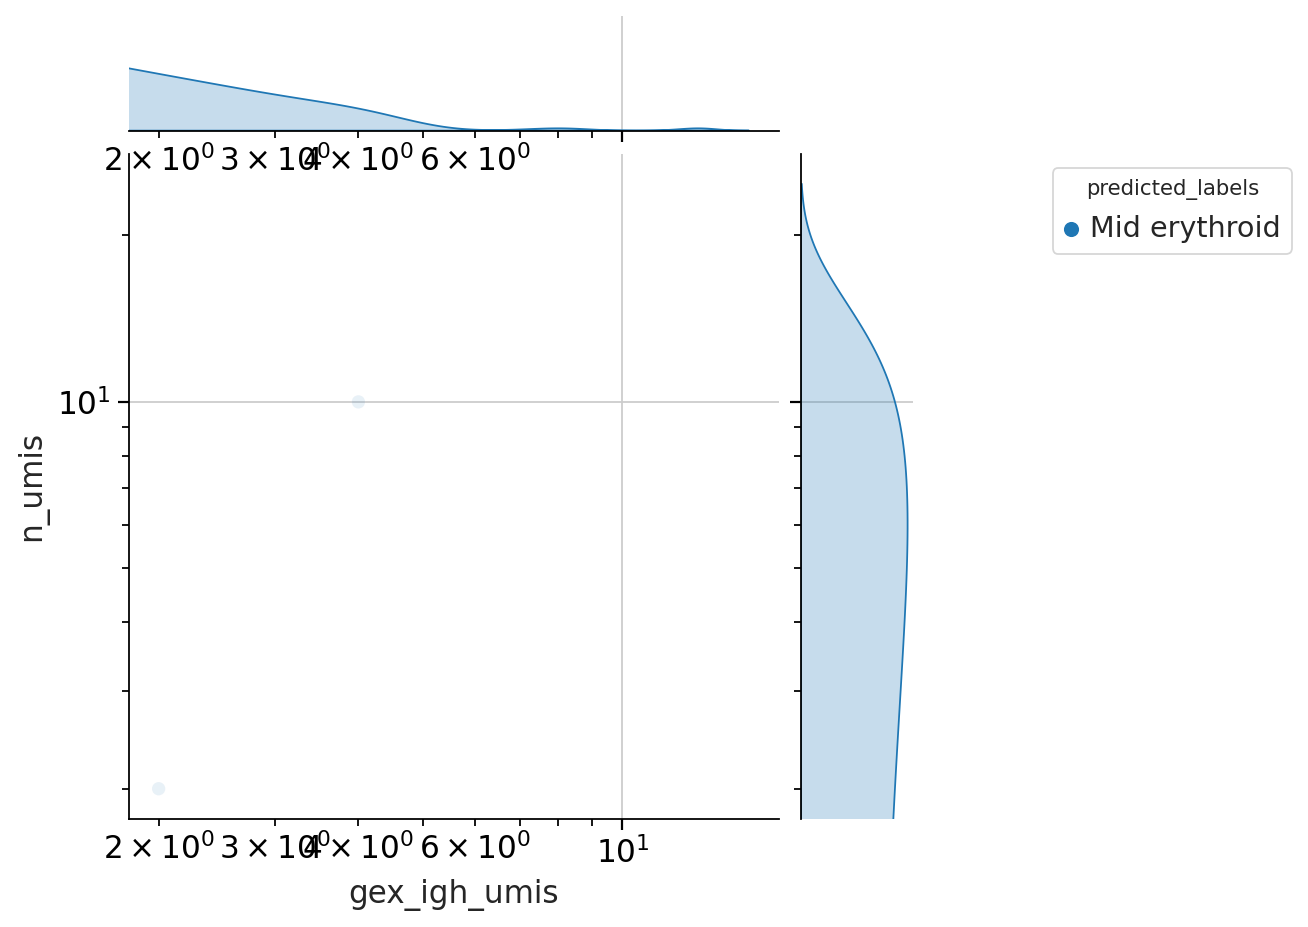

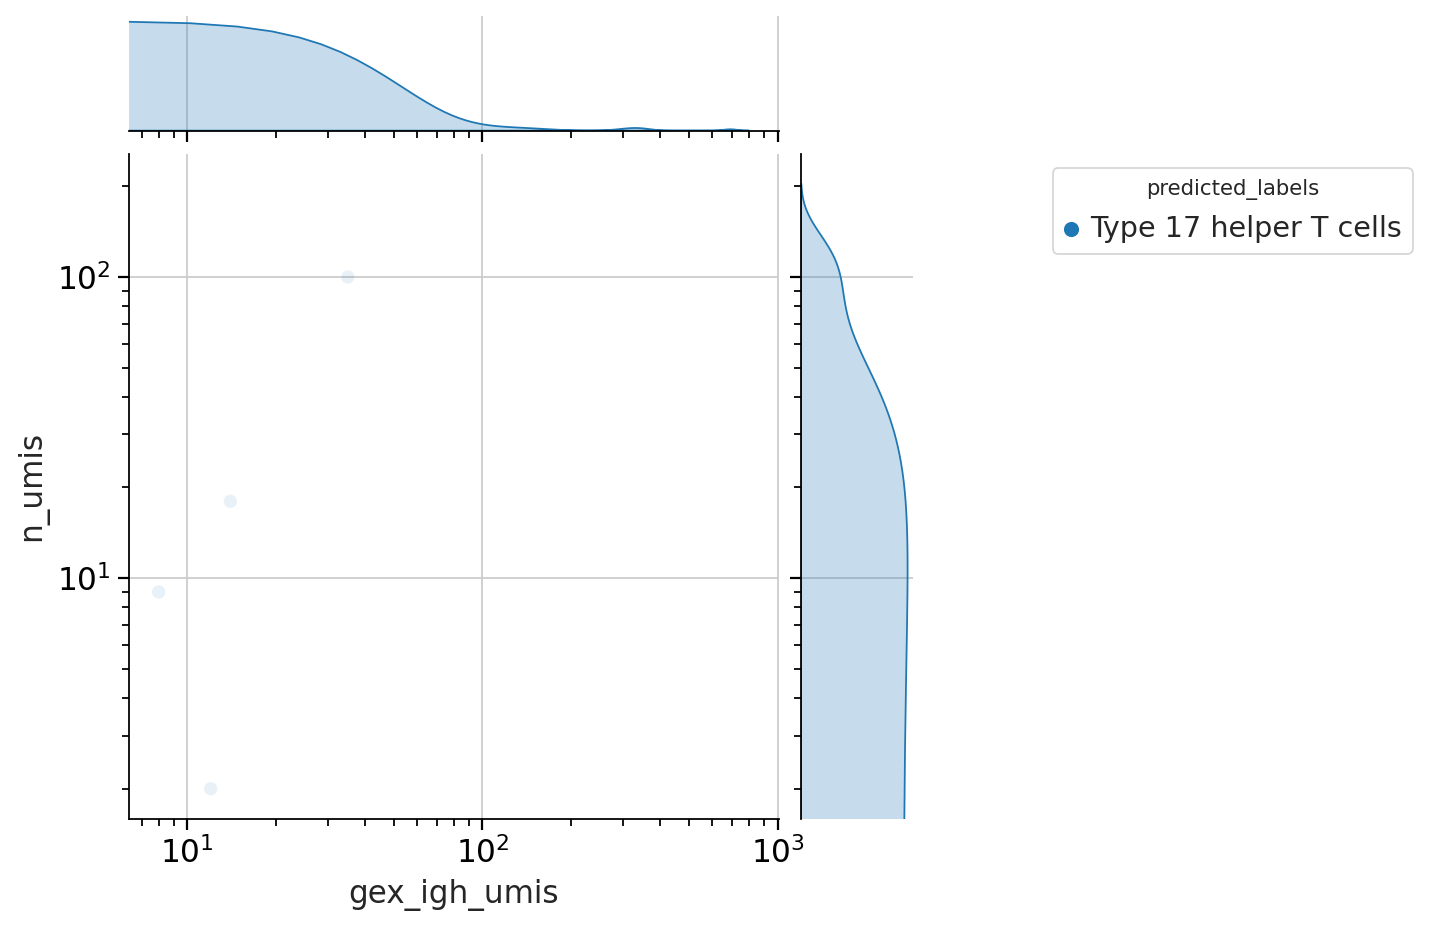

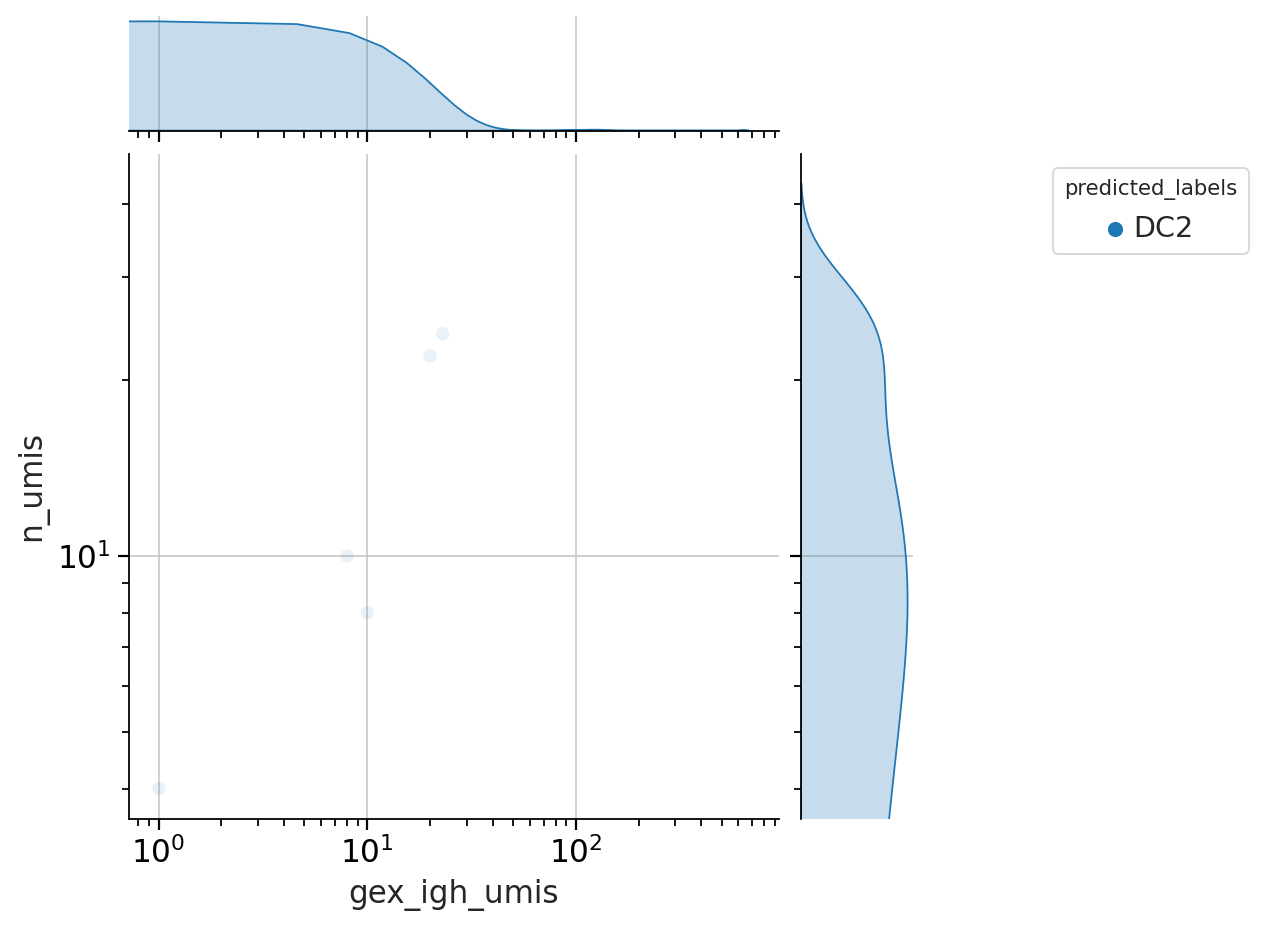

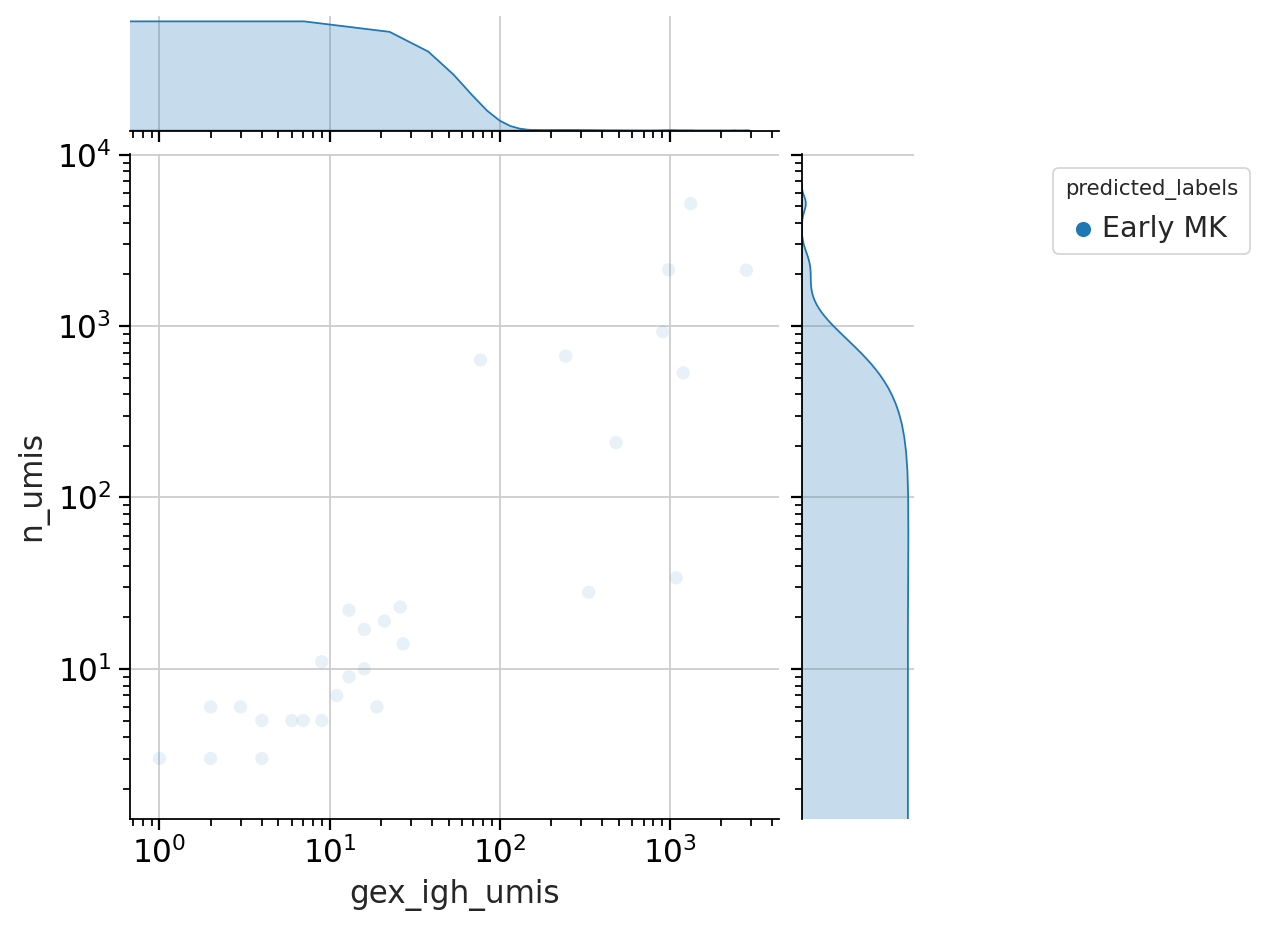

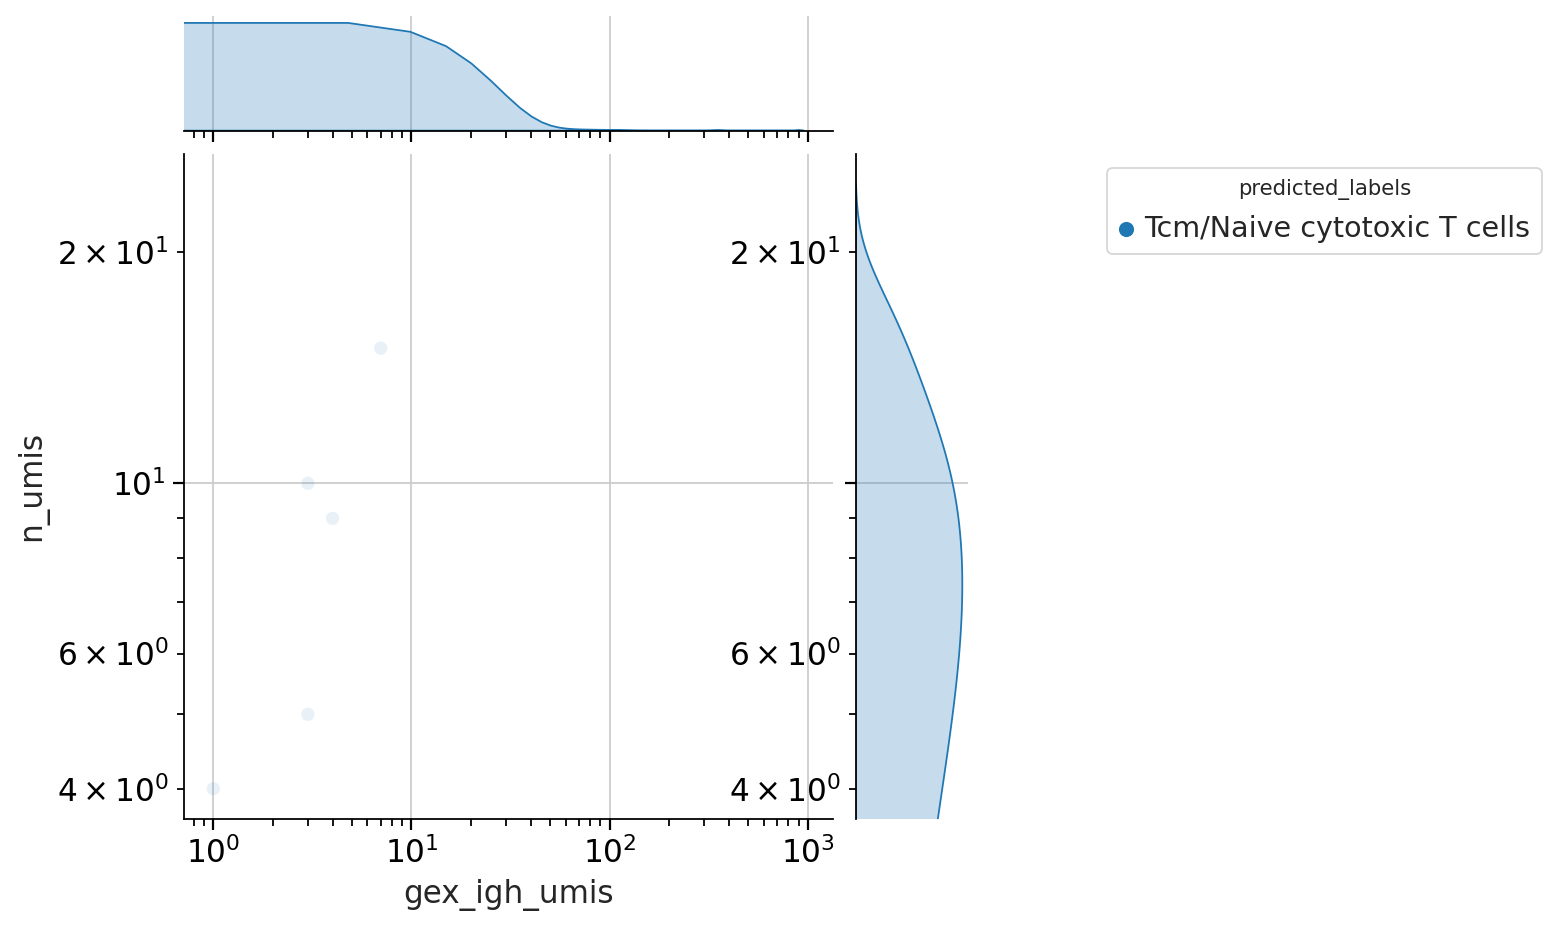

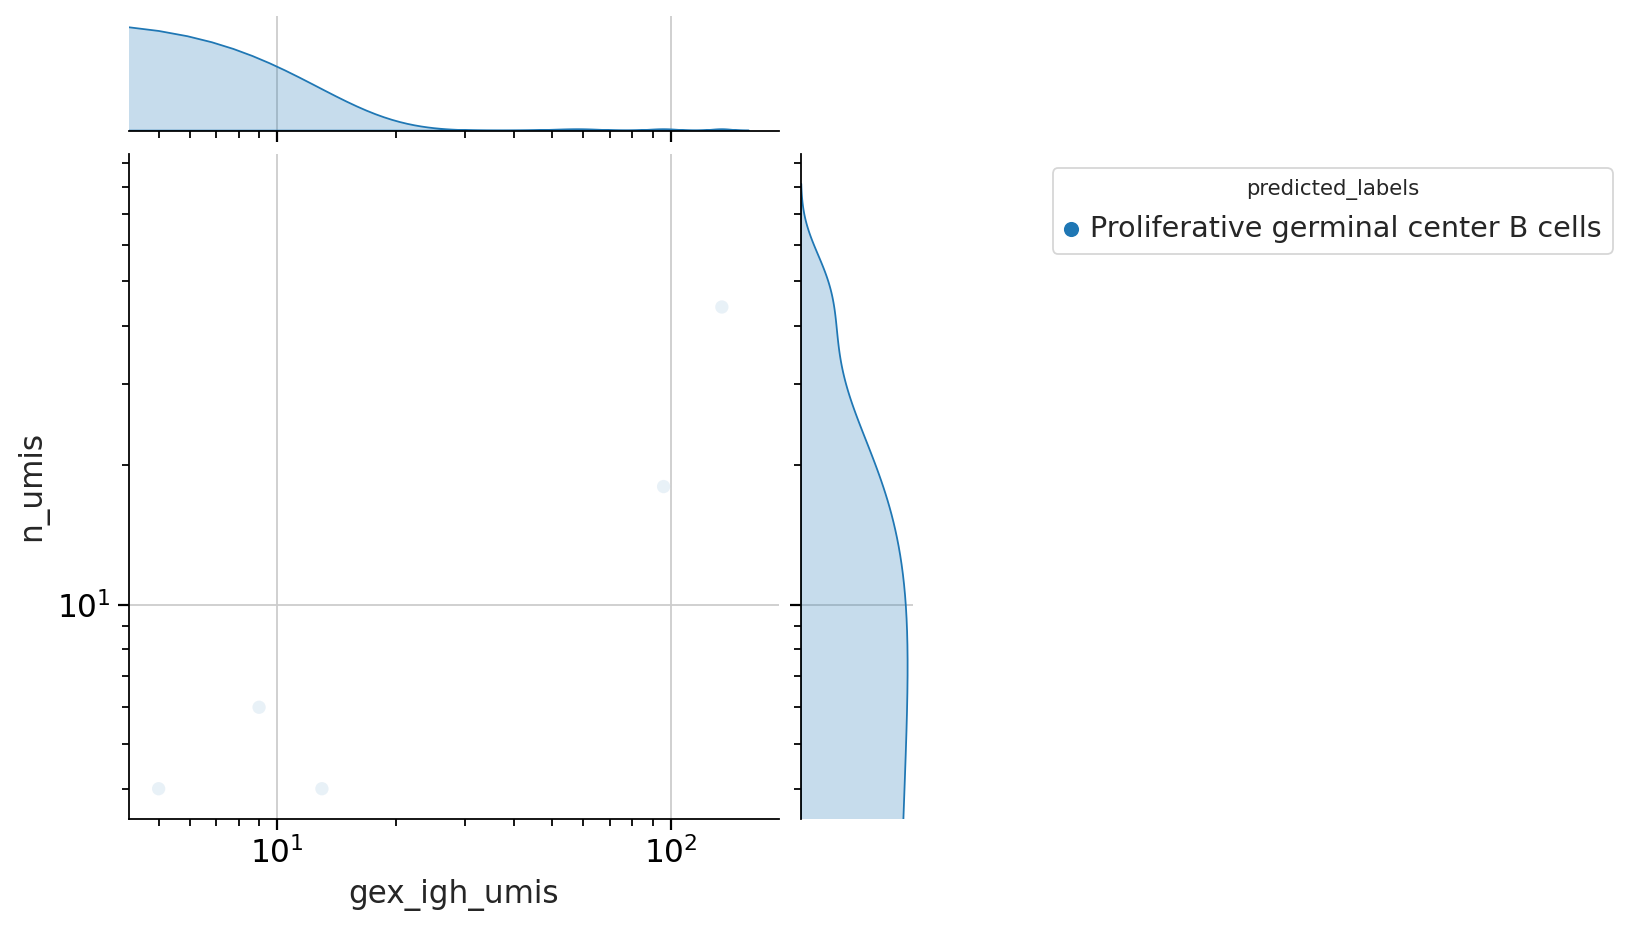

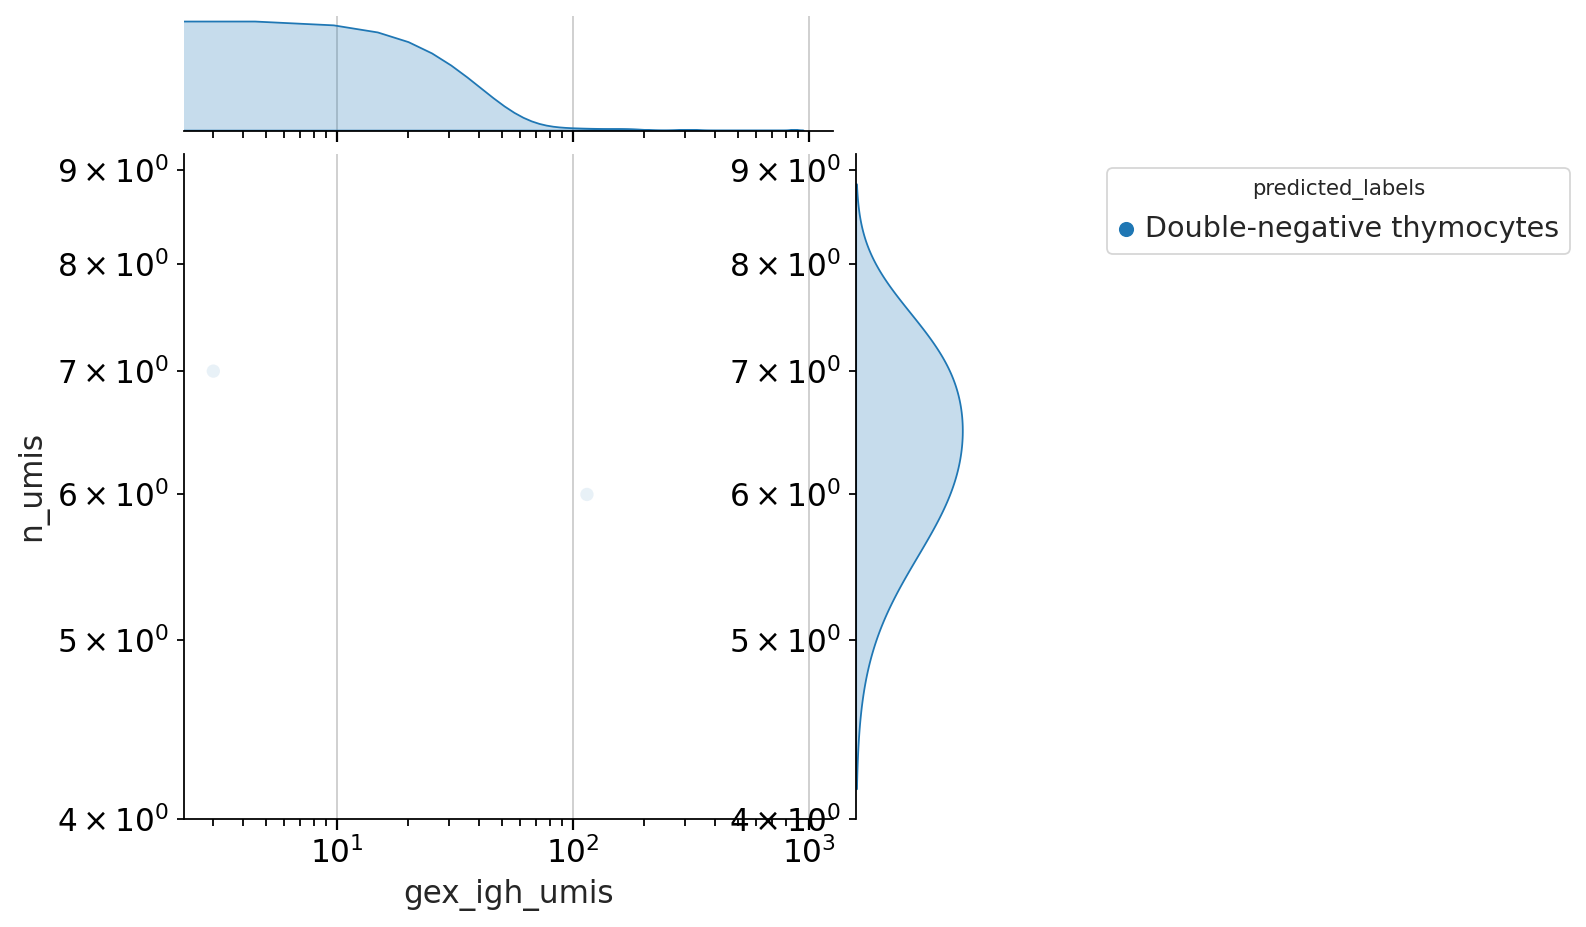

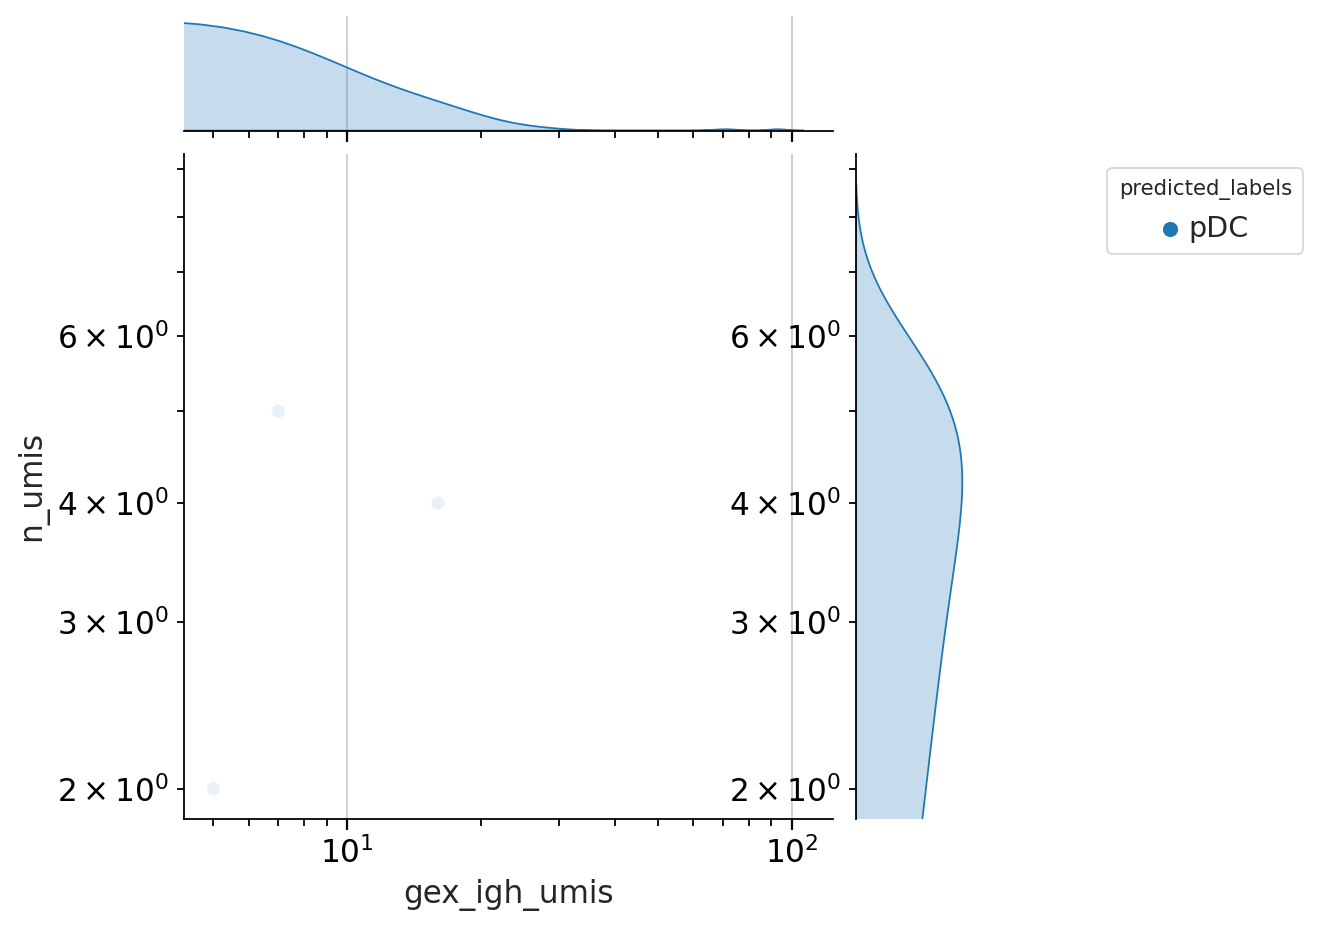

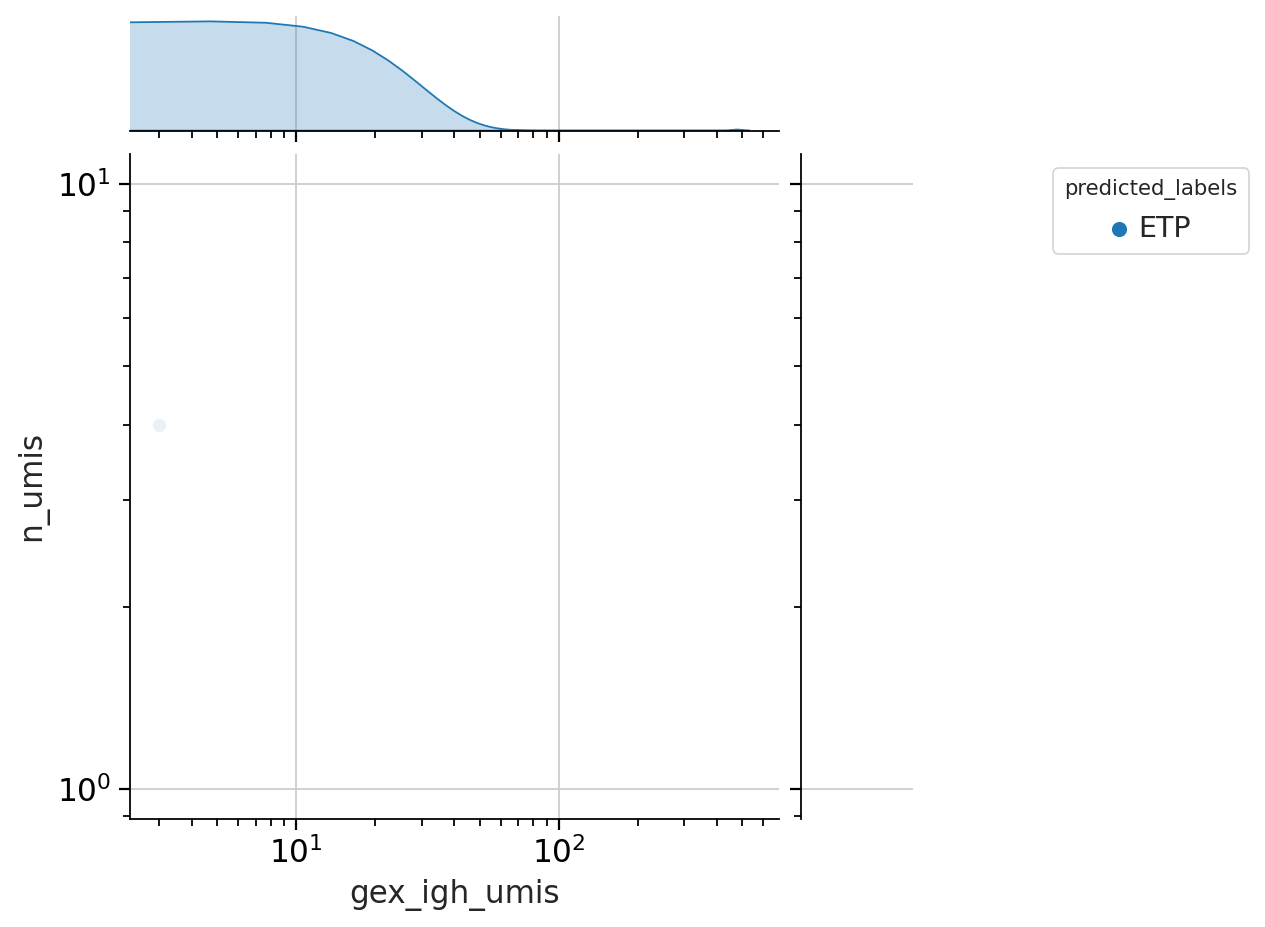

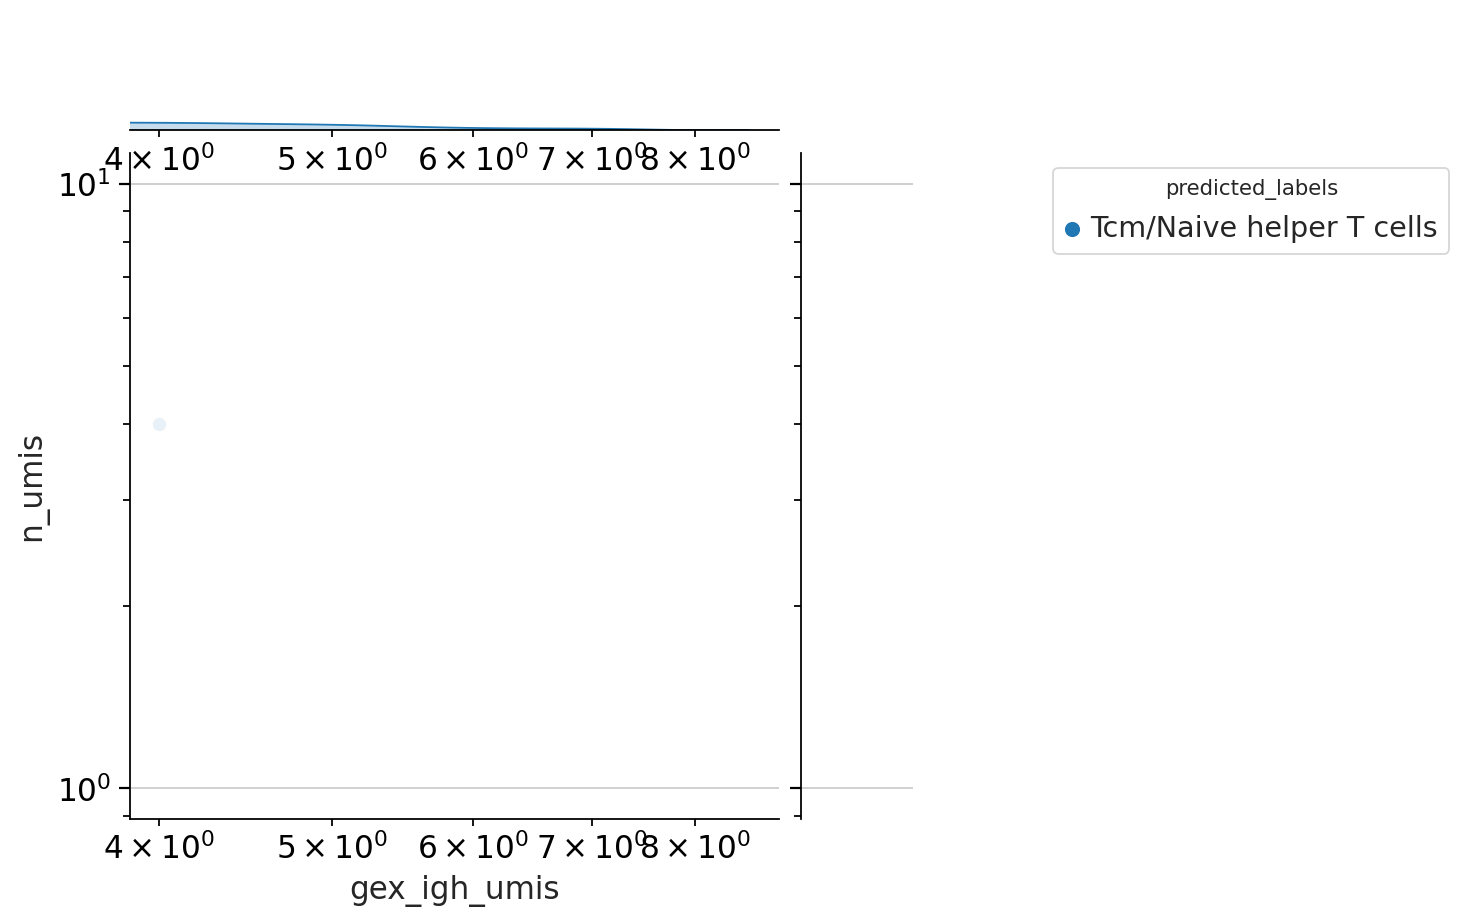

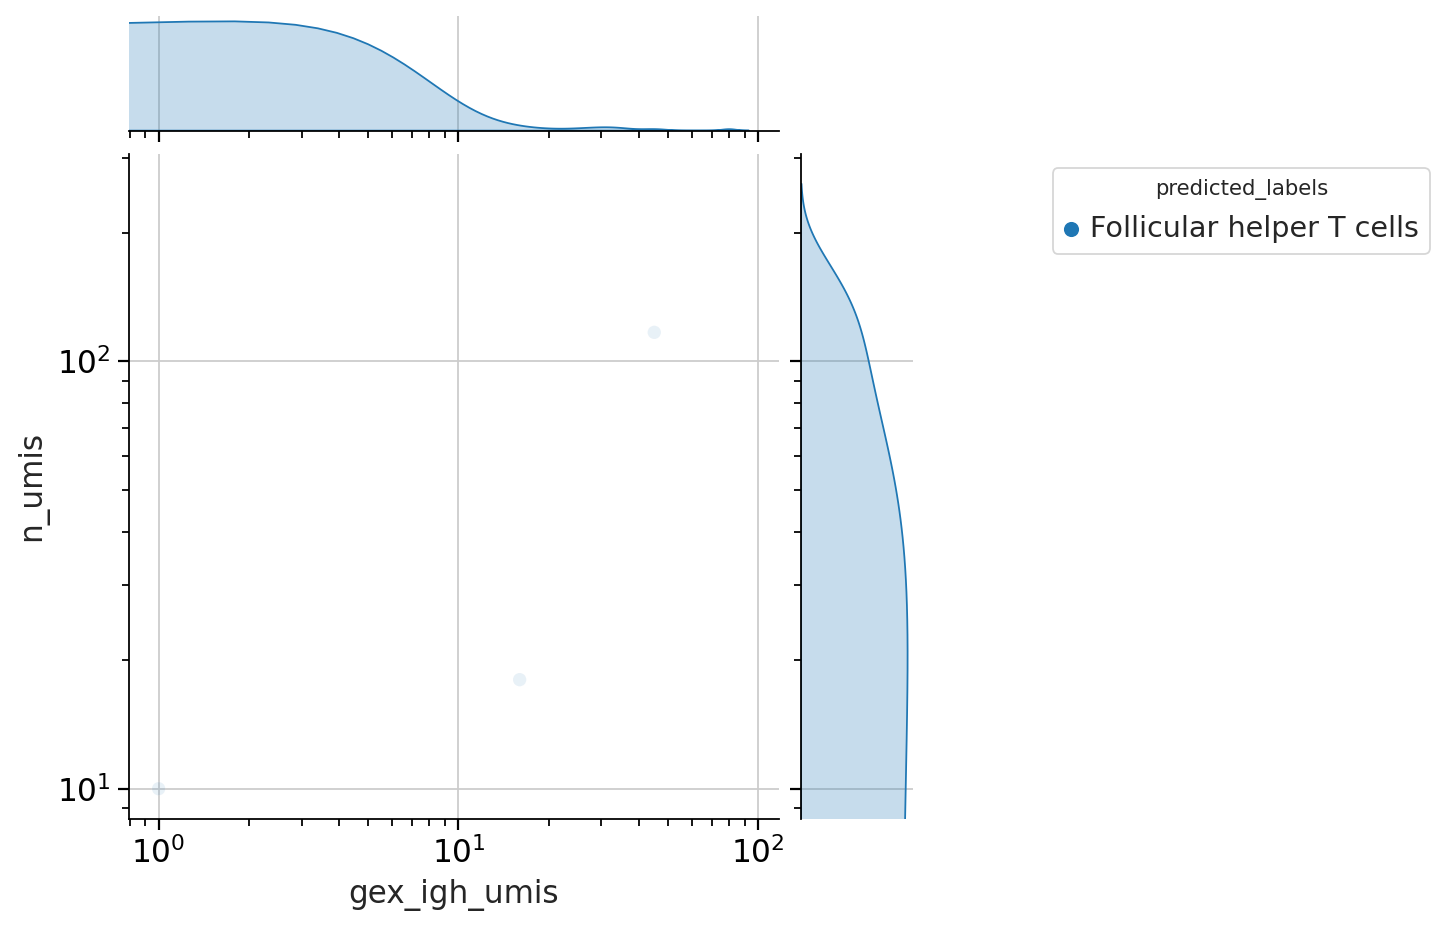

In [33]:
all_data = adata.obs
subsample = False
hue = "predicted_labels"
y = "n_umis"
x = "gex_igh_umis"
kind = 'scatter'
if subsample:
    data = data.sample(n=100, replace=True)
for label in all_data.predicted_labels.unique():
    data = all_data[all_data.predicted_labels == label]
    data.predicted_labels.cat.remove_unused_categories(inplace = True)
    g = sns.jointplot(data, x = x, y = y, lw = 2, kind = kind, hue = hue, alpha = 0.1)
    sns.move_legend(g.ax_joint, "upper left", bbox_to_anchor=(1.4, 1))
    plt.xscale('log')
    plt.yscale('log')
    label = "_".join(label.split('/'))
    save_figure(g.fig, "{}_{}_{}_{}_jointplot".format(y,x,label, kind))
        

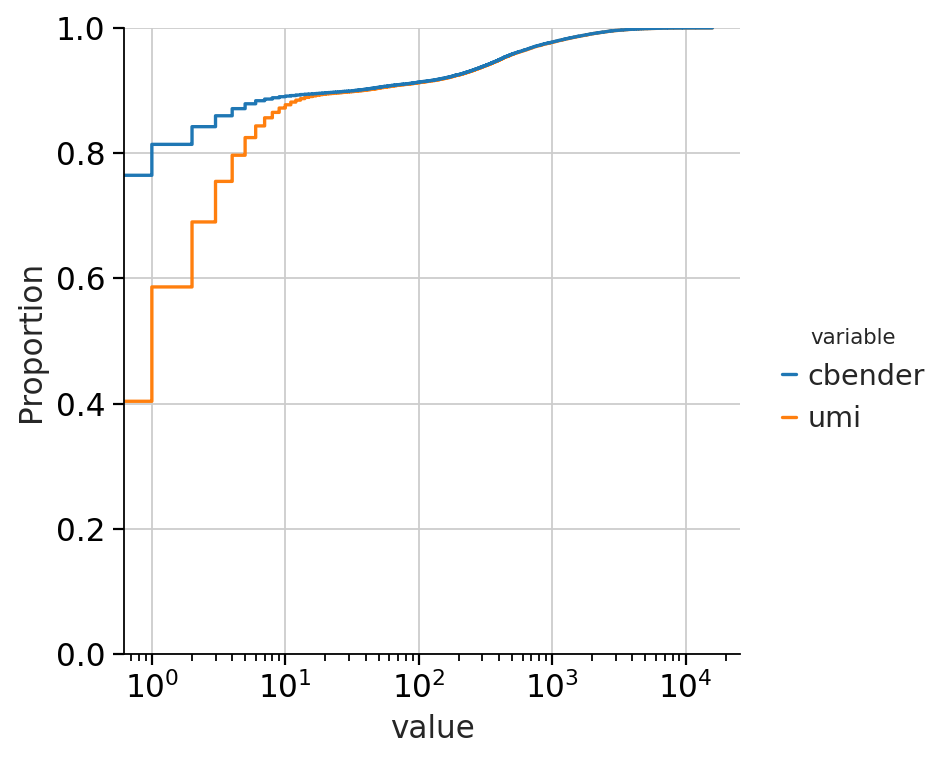

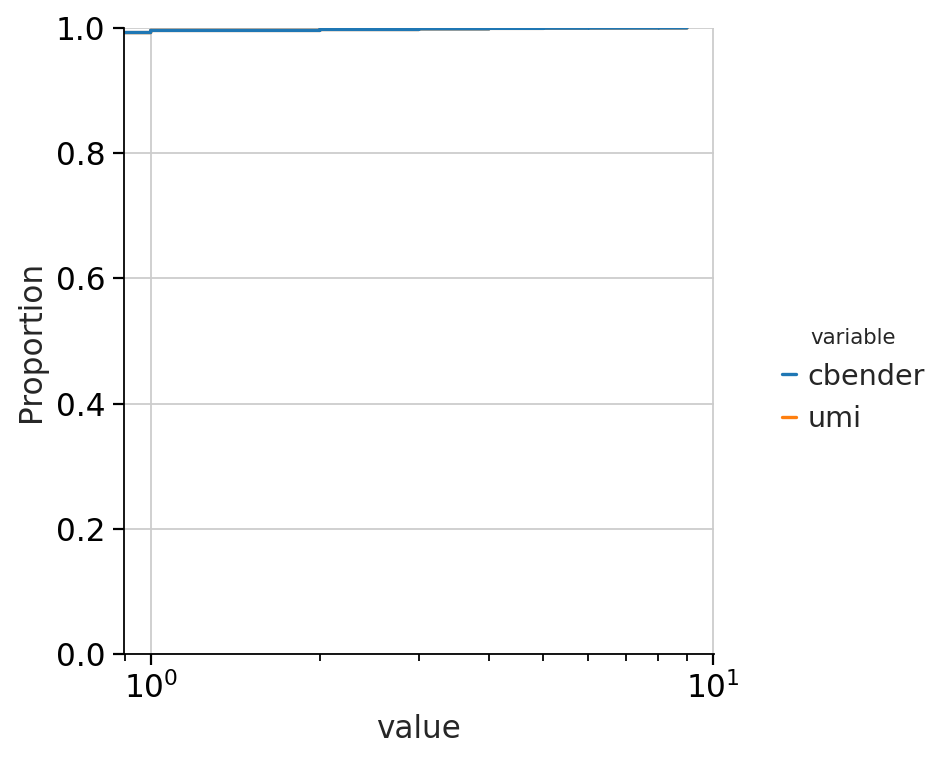

In [18]:
gene = "IGKC"

_umi = sc.get.obs_df(adata, keys = gene, layer='umi_counts')
_bg = sc.get.obs_df(adata, keys = gene, layer='background_removed')

data = pd.concat([_bg, _umi], axis=1)

data.columns = ['cbender', 'umi']

data = data.melt()

sns.displot(data, x = 'value', hue = 'variable', kind = 'ecdf', log_scale=True)

gene = "CD3E"

_umi = sc.get.obs_df(adata, keys = gene, layer='umi_counts')
_bg = sc.get.obs_df(adata, keys = gene, layer='background_removed')

data = pd.concat([_bg, _umi], axis=1)

data.columns = ['cbender', 'umi']

data = data.melt()

sns.displot(data, x = 'value', hue = 'variable', kind = 'ecdf', log_scale=True)

In [19]:
sc.tl.leiden(adata, key_added='{}_leiden'.format(tissue))

/home/michaelswift/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/home/michaelswift/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/home/michaelswift/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/tools/_rank_gene

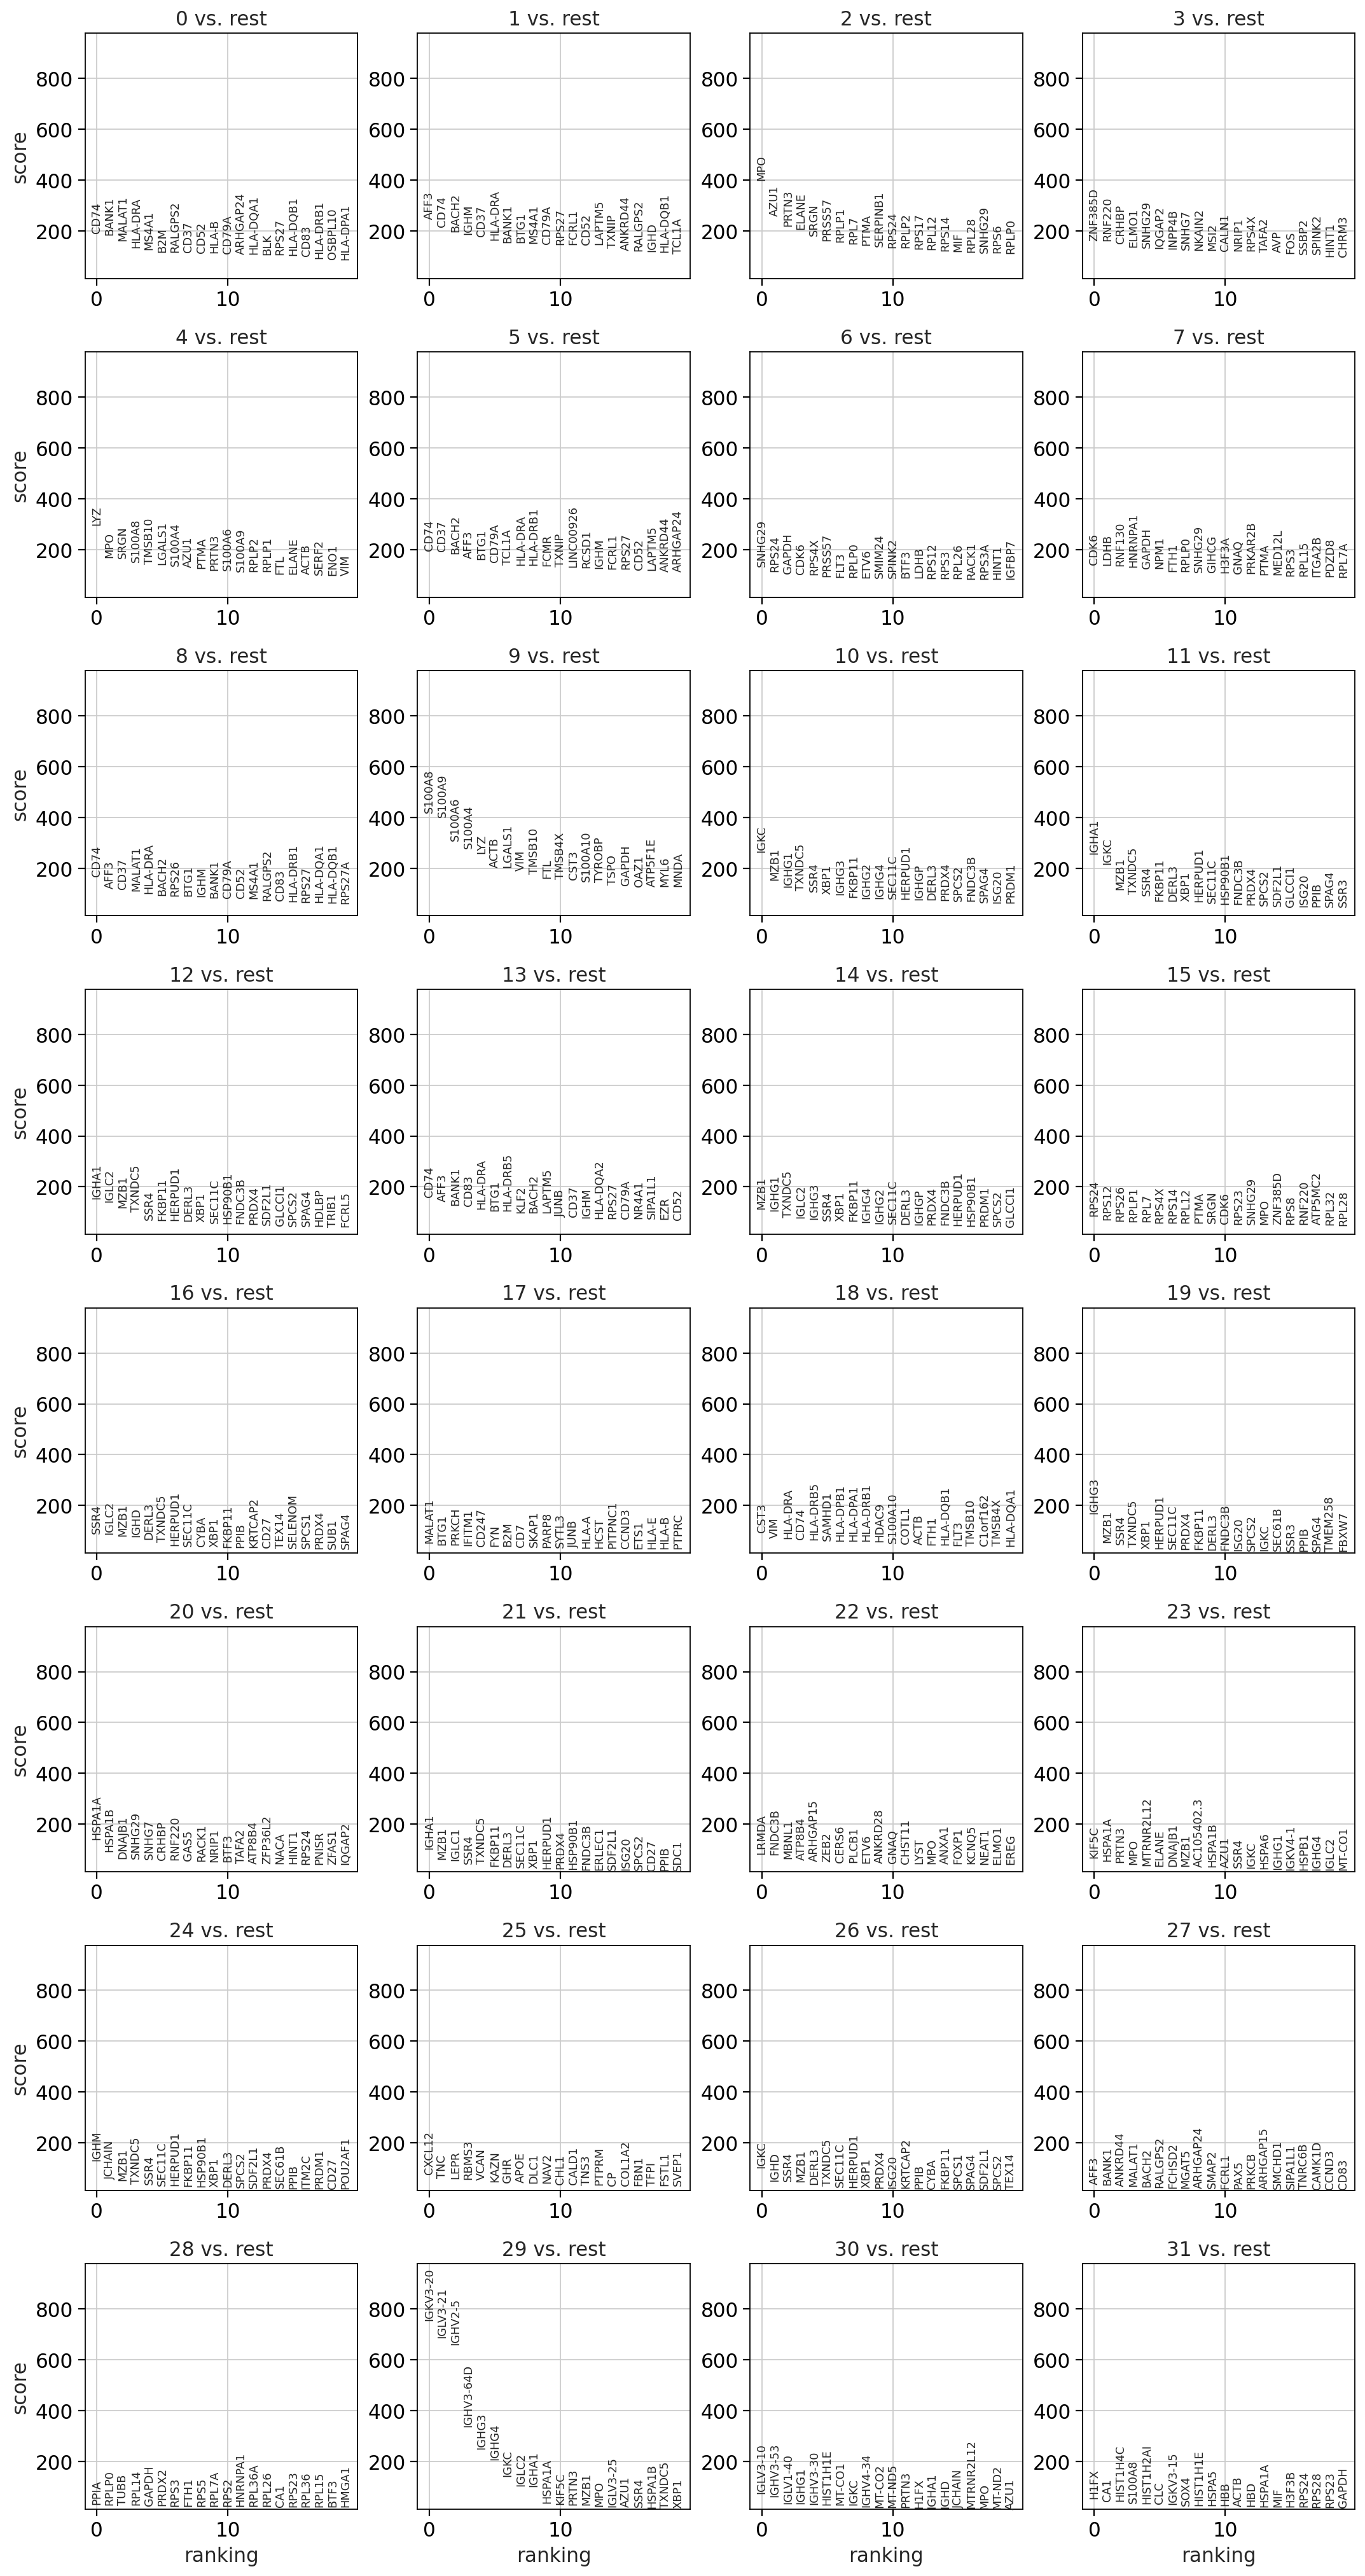

In [20]:
sc.tl.rank_genes_groups(adata, groupby='{}_leiden'.format(tissue))
sc.pl.rank_genes_groups(adata)

In [21]:
adata.obs['B_cell'] = adata.obs.predicted_labels.str.contains('B cell|Plasma|B-')

In [22]:
df = adata.obs[['sample_uid', 'majority_voting', 'n_genes', 'total_counts', 'total_counts_mt', '{}_leiden'.format(tissue), 'tissue', ]]

In [23]:
df.to_csv('{}_obs.tab'.format(tissue), sep = '\t')

## Filter Leiden groups which appear to be other celltypes

In [24]:
data = pd.DataFrame(adata.obs.groupby('sample_uid').B_cell.value_counts(normalize = True))

In [25]:
data.columns = ['fraction_b_cells']

In [26]:
data = data.reset_index()

In [27]:
data[data.B_cell]

sample_uid  B_cell  fraction_b_cells
0   TBd1_frozen_BMb    True          0.529238
3   TBd2_frozen_BMa    True          0.468391
5   TBd2_frozen_BMb    True          0.450016
6    TBd3_fresh_B20    True          0.604273
8   TBd3_frozen_BMa    True          0.550439
11  TBd3_frozen_BMb    True          0.488296
13  TBd4_frozen_BMa    True          0.430175
15  TBd4_frozen_BMb    True          0.444415
16   TBd5_frozen_BM    True          0.744982
18    TBd6_fresh_BM    True          0.791830

In [28]:
file_name = "{}_bcell_fraction.tab".format(tissue)
data.to_csv(file_name, sep = '\t')

In [29]:
cell_group = 'leiden'
bcells = adata[adata.obs[cell_group].isin(['0', '2', '5', '6'])]
